In [1]:
import numpy as np
import logging
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import scipy.signal as sps
from pprint import pprint

sys.path.insert(1, '/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/')
sys.path.insert(1, '/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/src')
import importlib
import simulation_strategies, collapse, plotting, utils, analtyic_formulas
importlib.reload(simulation_strategies)
importlib.reload(collapse)
importlib.reload(plotting)
importlib.reload(utils)
importlib.reload(analtyic_formulas)
from simulation_strategies import *
from collapse import *
from plotting import *
from utils import *
from analtyic_formulas import *
import cProfile
import pstats

from scipy.interpolate import UnivariateSpline

import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

import faulthandler
faulthandler.enable(all_threads=True)

In [2]:
# Default plotting settings
def my_mpl():
    plt.rc('font', family='serif', size=12)
    plt.rc('axes', grid=True)
    plt.rc('lines', lw=3)
    ts = 8
    plt.rc('xtick.minor', size=ts-2)
    plt.rc('ytick.minor', size=ts-2)
    plt.rc('xtick.major', size=ts)
    plt.rc('ytick.major', size=ts)
    plt.rc('figure', figsize=[12, 9])
my_mpl()
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [3]:
t_i = 1
G = 1
rho_H = 1/(6*np.pi*G*t_i**2)
H0 = 2/(3*t_i)

def compute_r0_min(r_min, r_max, N):
    """
    Compute r0_min such that the spacing dR in np.linspace(r0_min, r_max, N)
    satisfies dR = r0_min - r_min. That is, the inner edge of the innermost shell is at r_min.
    
    Parameters:
    - r_min (float): The minimum radius.
    - r_max (float): The maximum radius.
    - N (int): Number of points.
    
    Returns:
    - float: The computed r0_min.
    """
    return (r_max + r_min * (N - 1)) / N

def make_config(no_pm=False, **kwargs):
    # Set defaults directly in kwargs
    kwargs.setdefault('r_min', 0)
    kwargs.setdefault('r_max', 1)
    kwargs.setdefault('N', 1)
    kwargs.setdefault('H', 0)
    kwargs.setdefault('rho_bar', rho_H)
    kwargs.setdefault('delta', 0)
    kwargs.setdefault('j_coef', 0)
    kwargs.setdefault('r_min_strategy', 'nothing')
    kwargs.setdefault('t_max', 5000)
    kwargs.setdefault('dt_min', 0)
    kwargs.setdefault('stepper_strategy', 'leapfrog_kdk')
    kwargs.setdefault('timescale_strategy', 'dyn')
    kwargs.setdefault('save_strategy', 'vflip')
    kwargs.setdefault('safety_factor', 1e-2)
    kwargs.setdefault('save_dt', 1e-2)
    kwargs.setdefault('initial_radius_strategy', 'r0min_start_equal')
    kwargs.setdefault('m_enc_strategy', 'inclusive')
    kwargs.setdefault('density_strategy', 'background_plus_tophat2')
    kwargs.setdefault('timestep_strategy', 'simple_adaptive')
    kwargs.setdefault('problematic_shell_strategy', 'energy')
    kwargs.setdefault('energy_strategy', 'kin_grav_rot_absorbed')
    
    # Set r_th default after r_max is set
    kwargs.setdefault('tophat_radius', kwargs['r_max'])

    # Extract values for computation
    r_min = kwargs['r_min']
    r_max = kwargs['r_max']
    N = kwargs['N']
    rho_bar = kwargs['rho_bar']
    delta_i = kwargs['delta']
    r_th = kwargs['tophat_radius']
    j_coeff = kwargs['j_coef']
    #reflect_bool = kwargs['r_min_strategy'] == 'reflect'

    # m_pert = rho_bar * delta_i * 4/3 * np.pi * min(r_max, r_th)**3
    # if no_pm:
    #     point_mass = 0
    #     shell_volume_strategy = 'keep_edges'
    # else:
    #     point_mass = 4/3 * np.pi * r_min**3 * rho_bar * (1+delta_i)
    #     shell_volume_strategy = 'inner_not_zero'

    r0_min = compute_r0_min(r_min=r_min, r_max=r_max, N=N)
    #r_min_strategy = 'reflect' if reflect_bool else 'absorb'
    t_ta_strategy = 't_ta_cycloid'
    r_ta_strategy = 'r_ta_cycloid'
    #ang_mom_strategy = 'const' if j_coeff > 0 else 'zero'

    # Start with all user-supplied kwargs (now with defaults), then update/override with computed values
    config = dict(kwargs)
    config.update({
        'r0_min': r0_min,
        #'r_min_strategy': r_min_strategy,
        't_ta_strategy': t_ta_strategy,
        'r_ta_strategy': r_ta_strategy,
    })
    return config

def run_sc(config, profile=False, plot=True):
    sc = SphericalCollapse(config)
    if profile:
        # Profile the run method
        profiler = cProfile.Profile()
        profiler.enable()
        results = sc.run()
        profiler.disable()
        # Print the profiling results
        stats = pstats.Stats(profiler).sort_stats('cumulative')
        stats.print_stats(50)  # Print top 50 time-consuming functions
    else:
        results = sc.run()
    if not plot:
        return sc, results, None
    plotter = SimulationPlotter(results, sc)
    plotter.plot_radius_analysis()
    plotter.plot_mass_density_timescales()
    plotter.plot_energy_analysis()
    return sc, results, plotter

def find_turnaround_indices(results):
    r_data = results['r']
    
    # Find turnaround indices for each shell
    ta_indices = []
    for i in range(r_data.shape[1]):
        # Find indices of local maxima for this shell
        maxima_indices = argrelmax(r_data[:, i])[0]
        # If maxima found, use the first one; otherwise use None
        ta_idx = maxima_indices[0] if len(maxima_indices) > 0 else None
        ta_indices.append(ta_idx)
    
    # Process shells that have turnaround points
    valid_shells = [i for i in range(r_data.shape[1]) if ta_indices[i] is not None]

    r_ta = np.zeros(r_data.shape[1])
    t_ta = np.zeros(r_data.shape[1])
    
    for i in valid_shells:
        r_ta[i] = r_data[ta_indices[i], i]
        t_ta[i] = results['t'][ta_indices[i]]
    r_normalized = np.zeros_like(r_data)
    for i in valid_shells:
        r_normalized[:, i] = r_data[:, i] / r_ta[i]
    return r_ta, t_ta, r_normalized

def plot_results(results, sc, params=None, nta=None, fn=None):
    r_ta, t_ta, r_normalized = find_turnaround_indices(results)

    tvals = results['t']
    rvals = results['r']
    mvals = results['m'][0,:]
    mvals_w_point_mass = mvals.copy()
    if sc is not None:
        N = sc.N
        mvals_w_point_mass[0] += sc.point_mass
    else:
        N = params['N']
        mvals_w_point_mass += params['point_mass']
    mencvals = results['m_enc']
    #volvals = 4/3 * np.pi * np.array([np.diff(np.array([0, *rvals[i,:]]))**3 for i in range(len(rvals))])
    rhovals = results['rho_r']

    rho0 = results['rho_r'][0,:]
    #vol0 = volvals[0,:]
    rvals0 = rvals[0,:]
    menc0 = mencvals[0,:]

    upper_bounds = rvals0
    if sc is not None:
        lower_bounds = np.array([sc.r_min, *rvals0[:-1]])
    else:
        lower_bounds = np.array([params['r_min'], *rvals0[:-1]])
    volumes = 4/3 * np.pi * (upper_bounds**3 - lower_bounds**3)

    cmap = plt.cm.viridis
    r_min, r_max = np.min(rvals0), np.max(rvals0)
    norm = mpl.colors.Normalize(vmin=r_min, vmax=r_max)

    # #plt.plot(rvals0, rho0/rho_H, label='initial profile')
    # #plt.plot(rvals0, 1/rho_H * mvals_w_point_mass/vol0, label='initial mass density')
    # plt.plot(rvals0, mvals/(rho_H * volumes), label='initial mass density')
    # plt.xlabel('r')
    # plt.ylabel(r'$\rho/\rho_H$')
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.legend()

    # plt.figure()
    # plt.plot(rvals0, menc0, label='initial enclosed mass')
    # plt.xlabel('r')
    # plt.ylabel(r'$M_{enc}$')
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.legend()

    


    # 1. Create a grid of normalized time values
    max_ta = (tvals[-1]+1)/np.min(t_ta[t_ta != 0])
    n_points = int(20*max_ta)
    norm_time_grid = np.linspace(
        0, 
        max_ta, 
        n_points
    )

    mean_r = np.empty(n_points)
    std_r = np.empty(n_points)
    median_r = np.empty(n_points)

    for j, norm_time in enumerate(norm_time_grid):
        r_values_at_time = []
        for i in range(r_normalized.shape[1]):
            shell_norm_time = (tvals + 1) / t_ta[i]
            # Only interpolate if norm_time is within the shell's time range
            if norm_time >= shell_norm_time[0] and norm_time <= shell_norm_time[-1]:
                r_val = np.interp(norm_time, shell_norm_time, r_normalized[:, i])
                r_values_at_time.append(r_val)
        if r_values_at_time:
            mean_r[j] = np.mean(r_values_at_time)
            std_r[j] = np.std(r_values_at_time)
            median_r[j] = np.median(r_values_at_time)
        else:
            mean_r[j] = np.nan
            std_r[j] = np.nan

    # 2. Plot, skipping nan values
    valid = ~np.isnan(mean_r)


    cmap = plt.cm.viridis
    r_min, r_max = np.min(rvals0), np.max(rvals0)
    norm = mpl.colors.Normalize(vmin=r_min, vmax=r_max)

    alpha = 1
    # for i in range(N):
    #     color = cmap(norm(i))
    #     plt.plot(tvals, rvals[:,i], alpha=alpha, color=color, lw=1)

    # plt.figure()
    # for i in range(N):
    #     color = cmap(norm(i))
    #     plt.semilogy(tvals, rvals[:,i], alpha=alpha, color=color, lw=1)

    plt.figure(figsize=(8, 6))
    print(tvals.shape, t_ta.shape)
    for i in range(N):
        color = cmap(norm(rvals0[i]))
        plt.plot((tvals+1)/t_ta[i], r_normalized[:,i], alpha=alpha, color=color, lw=4)

    theta_vals = np.linspace(0, 2*np.pi, 1000)
    plt.plot( 1/np.pi*(theta_vals-np.sin(theta_vals)), 0.5*(1-np.cos(theta_vals)), color='black', lw=2, ls='--', label='Analytic Cycloid')


    # plt.plot(norm_time_grid[valid], mean_r[valid], color='black', label='Mean', ls='--', lw=2)
    # plt.plot(norm_time_grid[valid], median_r[valid], color='black', label='Median', ls=':', lw=2)
    # plt.plot(norm_time_grid[valid], mean_r[valid] - std_r[valid], color='red', label='1$\sigma$ band', ls=':')
    # plt.plot(norm_time_grid[valid], mean_r[valid] + std_r[valid], color='red', ls=':')
    # plt.legend()
    plt.ylim(0, 1.1)
    #custom_yticks = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]
    #plt.yticks(custom_yticks)
    plt.xlim(-0.1, nta)
    plt.xlabel(r'$t/t_{ta}$')
    plt.ylabel(r'$r/r_{ta}$')
    plt.legend()
    plt.tight_layout()
    if fn is not None:
        plt.savefig(fn)

    plt.figure()
    plt.plot(norm_time_grid[valid], std_r[valid]/mean_r[valid], color='black', label=r'$\sigma$/mean', ls='-', lw=2)
    plt.yscale('log')
    plt.legend()

    # num_divisions = 5
    # for i in range(num_divisions):
    #     tval = tvals[-1]/num_divisions * (i+1)
    #     idx = np.argmin(np.abs(tvals - tval))
    #     rho = results['rho_r'][idx,:]
    #     rval = rvals[idx,:]
    #     menc = mencvals[idx,:]


    #     sorted_indices = np.argsort(rval)
    #     rval = rval[sorted_indices]
    #     rho = rho[sorted_indices]
    #     menc = menc[sorted_indices]
    #     mvals = mvals[sorted_indices]
    #     upper_bounds = rval
    #     lower_bounds = np.array([1, *rval[:-1]])
    #     vol = 4/3 * np.pi * (upper_bounds**3 - lower_bounds**3)
        
    #     plt.figure()
        
    #     plt.plot(rval[1:], mvals[1:]/(rho_H * (tval+1)**-2 * vol[1:]), label=f't={int(tval)}')
    #     plt.xlabel('r')
    #     plt.ylabel(r'$\rho/\rho_H$')
    #     plt.yscale('log')
    #     plt.xscale('log')
    #     plt.legend()

    #     plt.figure()
    #     plt.plot(rval, menc, label=f't={int(tval)}')
    #     plt.xlabel('r')
    #     plt.ylabel(r'$M_{enc}$')
    #     plt.yscale('log')
    #     plt.xscale('log')
    #     plt.legend()

def virial_helper(results, sc, params=None):
    if sc is not None:
        N = sc.N
    else:
        N = params['N']
    
    rvals = results['r'][:,-1]
    tvals = results['t']
    rho_vals = (results['m_enc'][:,-1]/(4/3*np.pi*rvals**3))/(1/(6*np.pi*(tvals+1)**2))
    ek, er, eg = results['e_k'], results['e_r'], results['e_g']
    TK, TJ, U = np.zeros(len(tvals)), np.zeros(len(tvals)), np.zeros(len(tvals))
    for time in range(len(tvals)):
        for n in range(N):
            if results['r'][time, n] <= rvals[time]:
                TK[time] += ek[time, n]/N
                TJ[time] += er[time, n]/N
                U[time] += eg[time, n]/N

    first_exceed_idx = np.where(rho_vals > 200)[0]
    if len(first_exceed_idx) > 0:
        t_200 = tvals[first_exceed_idx[0]]
    else:
        t_200 = np.nan
    vir_cond = TK+TJ+U/2
    vir_sgn = np.sign(vir_cond)
    vir_change_idx = np.where(np.diff(np.sign(vir_sgn)) != 0)[0] + 1
    if len(vir_change_idx) > 1:
        t_vir = tvals[vir_change_idx[1]]
    else:
        t_vir = np.nan

    return N, rvals, tvals, rho_vals, TK, TJ, U, t_200, t_vir


def plot_virial(results, sc, params=None, figsize=(12, 8), second_results=None, second_sc=None, second_params=None):
    
    N, rvals, tvals, rho_vals, TK, TJ, U, t_200, t_vir = virial_helper(results, sc, params)
    if second_results is not None:
        N2, rvals2, tvals2, rho_vals2, TK2, TJ2, U2, t_2002, t_vir2 = virial_helper(second_results, second_sc, second_params)
    
    plt.figure(figsize=figsize)
    if N > 1:
        cmap = plt.cm.viridis
        norm = mpl.colors.Normalize(vmin=0, vmax=N-1)
    for i in range(N):
        if N > 1:
            color = cmap(norm(i))
        else:
            color = 'C0'
        plt.plot((tvals+1)*17, results['r'][:,i]*2.35, color=color, lw=1)
    plt.axvline(x=(t_200+1)*17, color='black', ls='--', lw=2, label=fr'$t_{{200}}={(t_200+1)*17:.0f}$ Myr')
    plt.axvline(x=(t_vir+1)*17, color='red', ls=':', lw=2, label=fr'$t_{{vir}}={(t_vir+1)*17:.0f}$ Myr')
    
    plt.xlabel('t (Myr)')
    plt.ylabel('r (kpc)')
    plt.legend()

    if second_results is not None:
        plt.figure(figsize=figsize)
        if N2 > 1:
            cmap = plt.cm.viridis
            norm = mpl.colors.Normalize(vmin=0, vmax=N2-1)
        for i in range(N2):
            if N2 > 1:
                color = cmap(norm(i))
            else:
                color = 'C1'
            plt.plot((tvals2+1)*17, second_results['r'][:,i]*2.35, color=color, lw=1)
        plt.xlabel('t (Myr)')
        plt.ylabel('r (kpc)')
        plt.legend()


    plt.figure(figsize=figsize)
    plt.plot(101*(tvals+1)**(-2/3)-1, rvals*2.35)
    plt.axvline(x=101*(t_200+1)**(-2/3)-1, color='black', ls='--', lw=2, label=fr'$z_{{200}}={101*(t_200+1)**(-2/3)-1:.2f}$')
    plt.axvline(x=101*(t_vir+1)**(-2/3)-1, color='red', ls=':', lw=2, label=fr'$z_{{vir}}={101*(t_vir+1)**(-2/3)-1:.2f}$')
    if second_results is not None:
        plt.plot(101*(tvals2+1)**(-2/3)-1, rvals2*2.35, color='C1', lw=1,)
        plt.axvline(x=101*(t_2002+1)**(-2/3)-1, color='green', ls='--', lw=2, label=fr'$z_{{200}}={101*(t_2002+1)**(-2/3)-1:.2f}$')
        plt.axvline(x=101*(t_vir2+1)**(-2/3)-1, color='purple', ls=':', lw=2, label=fr'$z_{{vir}}={101*(t_vir2+1)**(-2/3)-1:.2f}$')
    plt.xlabel('z')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('r (kpc)')
    plt.legend()
    plt.grid(True, which="minor", axis="x")
    plt.gca().invert_xaxis()

    plt.figure(figsize=figsize)

    plt.plot((tvals+1)*17, rho_vals)
    plt.axvline(x=(t_200+1)*17, color='black', ls='--', lw=2, label=fr'$t_{{200}}={(t_200+1)*17:.0f}$ Myr')
    plt.axvline(x=(t_vir+1)*17, color='red', ls=':', lw=2, label=fr'$t_{{vir}}={(t_vir+1)*17:.0f}$ Myr')
    if second_results is not None:
        plt.plot((tvals2+1)*17, rho_vals2, color='C1', lw=1,)
        plt.axvline(x=(t_2002+1)*17, color='green', ls='--', lw=2, label=fr'$t_{{200}}={(t_2002+1)*17:.0f}$ Myr')
        plt.axvline(x=(t_vir2+1)*17, color='purple', ls=':', lw=2, label=fr'$t_{{vir}}={(t_vir2+1)*17:.0f}$ Myr')
    plt.xlabel('t (Myr)')
    plt.ylabel('rho/rho_H')
    plt.ylim(0, 200)
    plt.legend()

    plt.figure(figsize=figsize)
    plt.plot(101*(tvals+1)**(-2/3)-1, rho_vals)
    plt.axvline(x=101*(t_200+1)**(-2/3)-1, color='black', ls='--', lw=2, label=fr'$z_{{200}}={101*(t_200+1)**(-2/3)-1:.2f}$')
    plt.axvline(x=101*(t_vir+1)**(-2/3)-1, color='red', ls=':', lw=2, label=fr'$z_{{vir}}={101*(t_vir+1)**(-2/3)-1:.2f}$')
    if second_results is not None:
        plt.plot(101*(tvals2+1)**(-2/3)-1, rho_vals2, color='C1', lw=1,)
        plt.axvline(x=101*(t_2002+1)**(-2/3)-1, color='green', ls='--', lw=2, label=fr'$z_{{200}}={101*(t_2002+1)**(-2/3)-1:.2f}$')
        plt.axvline(x=101*(t_vir2+1)**(-2/3)-1, color='purple', ls=':', lw=2, label=fr'$z_{{vir}}={101*(t_vir2+1)**(-2/3)-1:.2f}$')
    plt.xlabel('z')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('rho/rho_H')
    plt.ylim(None, 200)
    plt.gca().invert_xaxis()
    plt.grid(True, which="minor", axis="x")
    plt.legend()

    plt.figure(figsize=figsize)
    plt.plot((tvals+1)*17, TK+TJ+U/2, label='TK+TJ+U/2')
    plt.plot((tvals+1)*17, TK+U/2, alpha=0.5, label='TK+U/2', color='C0')
    plt.axvline(x=(t_200+1)*17, color='black', ls='--', lw=2, label=fr'$t_{{200}}={(t_200+1)*17:.0f}$ Myr')
    plt.axvline(x=(t_vir+1)*17, color='red', ls=':', lw=2, label=fr'$t_{{vir}}={(t_vir+1)*17:.0f}$ Myr')
    if second_results is not None:
        plt.plot((tvals2+1)*17, TK2+TJ2+U2/2, color='C1', lw=1)
        plt.plot((tvals2+1)*17, TK2+U2/2, color='C1', lw=1, alpha=0.5)
        plt.axvline(x=(t_2002+1)*17, color='green', ls='--', lw=2, label=fr'$t_{{200}}={(t_2002+1)*17:.0f}$ Myr')
        plt.axvline(x=(t_vir2+1)*17, color='purple', ls=':', lw=2, label=fr'$t_{{vir}}={(t_vir2+1)*17:.0f}$ Myr')
    plt.xlabel('t (Myr)')
    plt.ylabel('TK+TJ+U/2')
    plt.ylim(-(TK[0]+TJ[0]+U[0]/2), TK[0]+TJ[0]+U[0]/2)
    plt.legend()

    plt.figure(figsize=figsize)
    plt.plot(101*(tvals+1)**(-2/3)-1, TK+TJ+U/2, label='TK+TJ+U/2')
    plt.plot(101*(tvals+1)**(-2/3)-1, TK+U/2, alpha=0.5, label='TK+U/2', color='C0')
    plt.axvline(x=101*(t_200+1)**(-2/3)-1, color='black', ls='--', lw=2, label=fr'$z_{{200}}={101*(t_200+1)**(-2/3)-1:.2f}$')
    plt.axvline(x=101*(t_vir+1)**(-2/3)-1, color='red', ls=':', lw=2, label=fr'$z_{{vir}}={101*(t_vir+1)**(-2/3)-1:.2f}$')
    if second_results is not None:
        plt.plot(101*(tvals2+1)**(-2/3)-1, TK2+TJ2+U2/2, color='C1', lw=1)
        plt.plot(101*(tvals2+1)**(-2/3)-1, TK2+U2/2, color='C1', lw=1, alpha=0.5)
        plt.axvline(x=101*(t_2002+1)**(-2/3)-1, color='green', ls='--', lw=2, label=fr'$z_{{200}}={101*(t_2002+1)**(-2/3)-1:.2f}$')
        plt.axvline(x=101*(t_vir2+1)**(-2/3)-1, color='purple', ls=':', lw=2, label=fr'$z_{{vir}}={101*(t_vir2+1)**(-2/3)-1:.2f}$')
    plt.xlabel('z')
    plt.ylabel('TK+TJ+U/2')
    plt.xscale('log')
    #plt.yscale('log')
    plt.ylim(-(TK[0]+TJ[0]+U[0]/2), TK[0]+TJ[0]+U[0]/2)
    plt.legend()
    plt.grid(True, which="minor", axis="x")
    plt.gca().invert_xaxis()

In [4]:
# r_max = 1.65
# j_coef = 0e-2
# N = 1000
# t_max = 50
# safety_factor = 1e-3
# save_dt = 1e-2
# delta = 0.15
# irs = 'equal_mass'
# ivs = 'peculiar'
# density_strategy = 'background_plus_power_law_total'
# accel_strategy, ang_mom_strategy = 'fdm4', 'zero' #'fdm4', 'const' 
# energy_strategy = 'kin_grav_rot_fdm_absorbed'
# softlen = 0
# hbar2_over_m2 = (6e-2)**2
# problematic_shell_strategy = 'nothing'

# tss = 'dyn_vel_acc_dbvel'
# mes = 'inclusive'
# save_strategy = 'default'
# r_min = 0
# gamma = -1
# thickness_coef = 0

- kepler w and w out symplectic integrator
- multishell top hat
- profile with bh compare to Bertschinger
- power law profile w large-ish angular momentum

2025-11-16 13:43:26,832 - collapse - INFO - Simulation setup complete


{'G': 1,
 'H': 0,
 'N': 1,
 'accel_strategy': 'soft_all',
 'ang_mom_strategy': 'const',
 'delta': 0,
 'density_strategy': 'const',
 'deque_size': 0,
 'drhodr_strategy': 'finite_diff',
 'dt': 1e-05,
 'dt_min': 0,
 'energy_strategy': 'kin_grav_rot',
 'gamma': 0,
 'hbar2_over_m2': 0,
 'initial_mass_strategy': 'integrated_mass',
 'initial_radius_strategy': 'equal_mass',
 'initial_v_strategy': 'hubble',
 'j_coef': 0.014141782065918275,
 'm_enc_strategy': 'inclusive',
 'm_pert': 1,
 'next_save_time': 0,
 'num_crossing': 0,
 'point_mass': 0,
 'point_mass_strategy': 'rmin_rho_r',
 'polytropic_coef': 0,
 'polytropic_index': -1,
 'pressure_strategy': 'zero',
 'problematic_shell_strategy': 'nothing',
 'r0_min': 1.9999,
 'r_max': 1.9999,
 'r_min': 0,
 'r_min_strategy': 'absorb',
 'r_small': 1,
 'r_ta_strategy': 'r_ta_cycloid',
 'relaxation_time': 0,
 'rho_bar': 0.05305164769729845,
 'safety_factor': 0.01,
 'save_dt': 0.01,
 'save_filename': 'thesis/kepler_symplectic-11-16-1.h5',
 'save_strategy': 

2025-11-16 13:43:50,299 - DEBUG - Saved dataset t with shape (36350,)
2025-11-16 13:43:50,303 - DEBUG - Saved dataset dt with shape (36350,)
2025-11-16 13:43:50,331 - DEBUG - Saved dataset r with shape (36350, 1)
2025-11-16 13:43:50,357 - DEBUG - Saved dataset v with shape (36350, 1)
2025-11-16 13:43:50,383 - DEBUG - Saved dataset a with shape (36350, 1)
2025-11-16 13:43:50,410 - DEBUG - Saved dataset m_enc with shape (36350, 1)
2025-11-16 13:43:50,435 - DEBUG - Saved dataset rho_r with shape (36350, 1)
2025-11-16 13:43:50,437 - WARNING - Skipping pressure because all values are None
2025-11-16 13:43:50,440 - WARNING - Skipping dpressure_drho because all values are None
2025-11-16 13:43:50,442 - WARNING - Skipping rho_prime because all values are None
2025-11-16 13:43:50,469 - DEBUG - Saved dataset e_tot with shape (36350, 1)
2025-11-16 13:43:50,495 - DEBUG - Saved dataset e_g with shape (36350, 1)
2025-11-16 13:43:50,544 - DEBUG - Saved dataset e_k with shape (36350, 1)
2025-11-16 13:

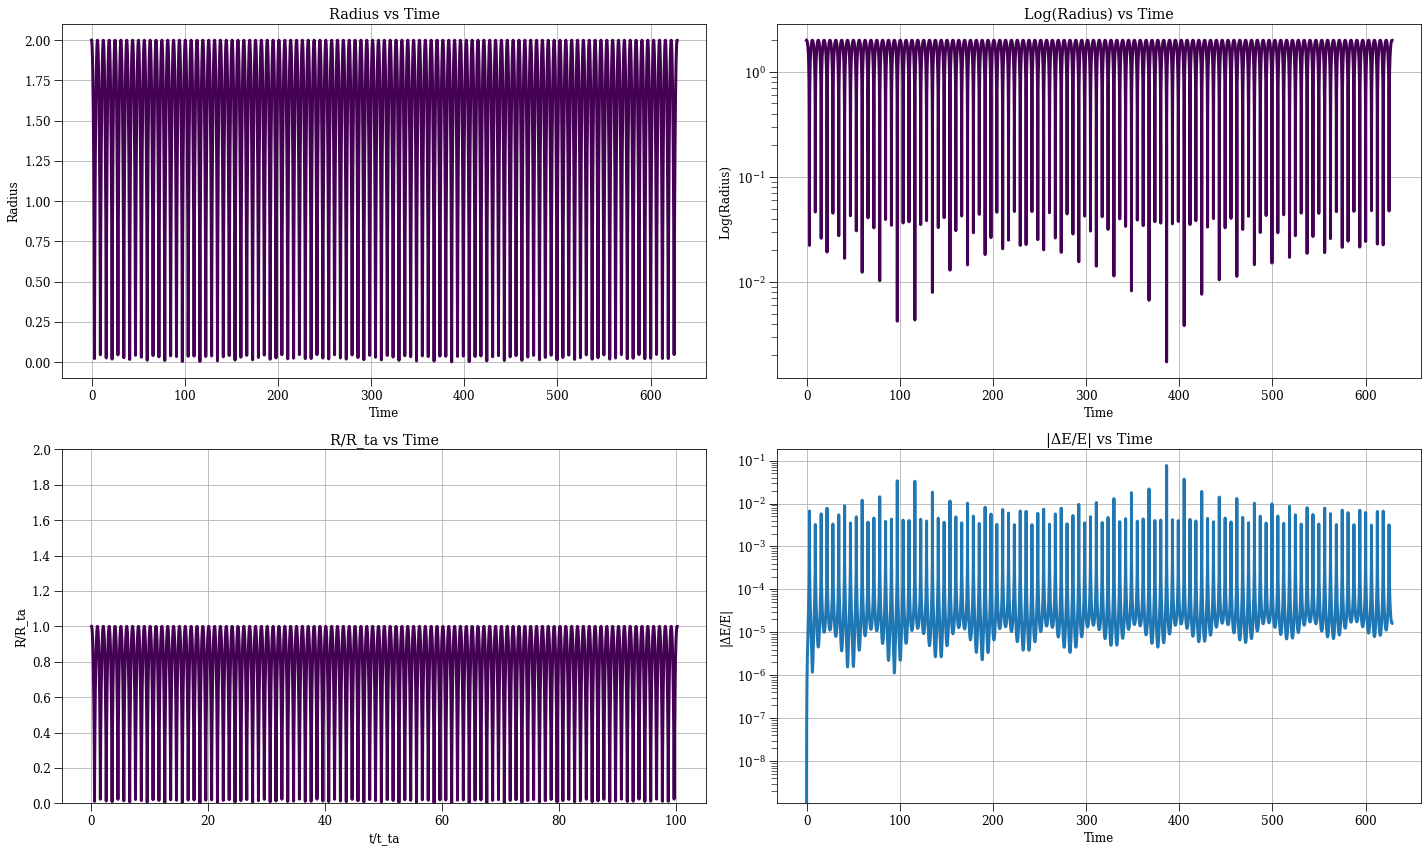

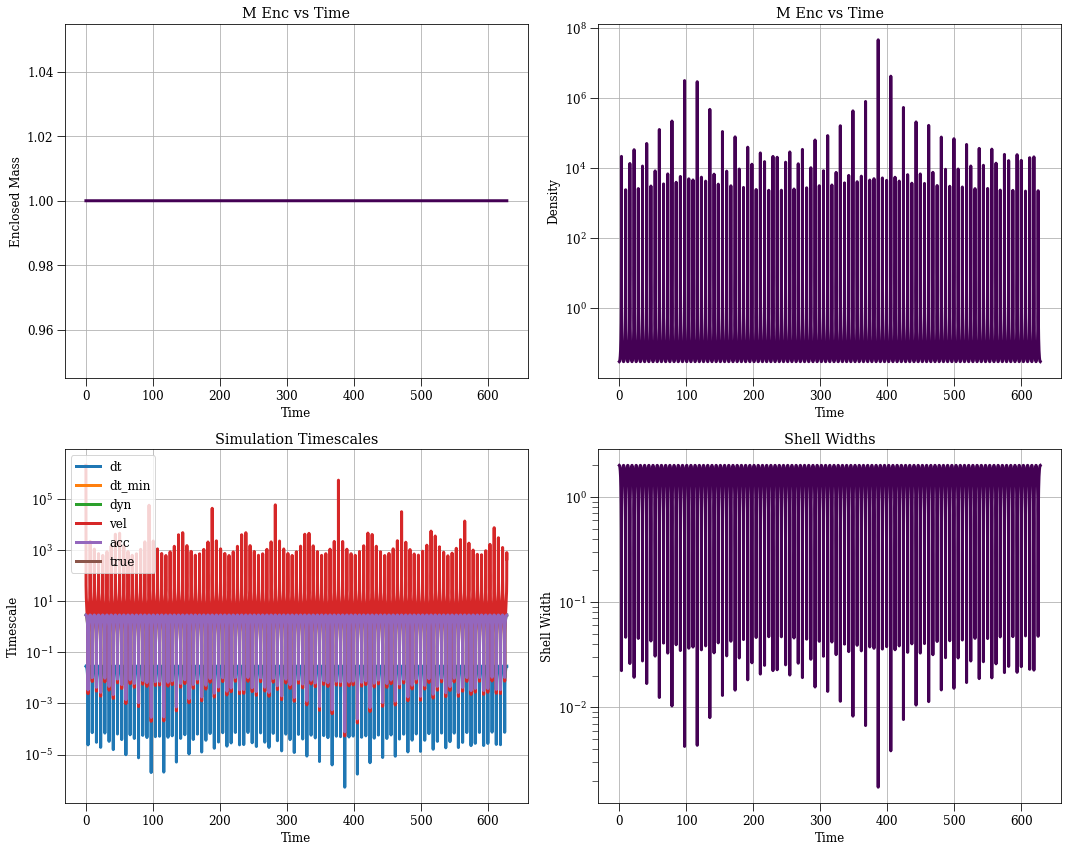

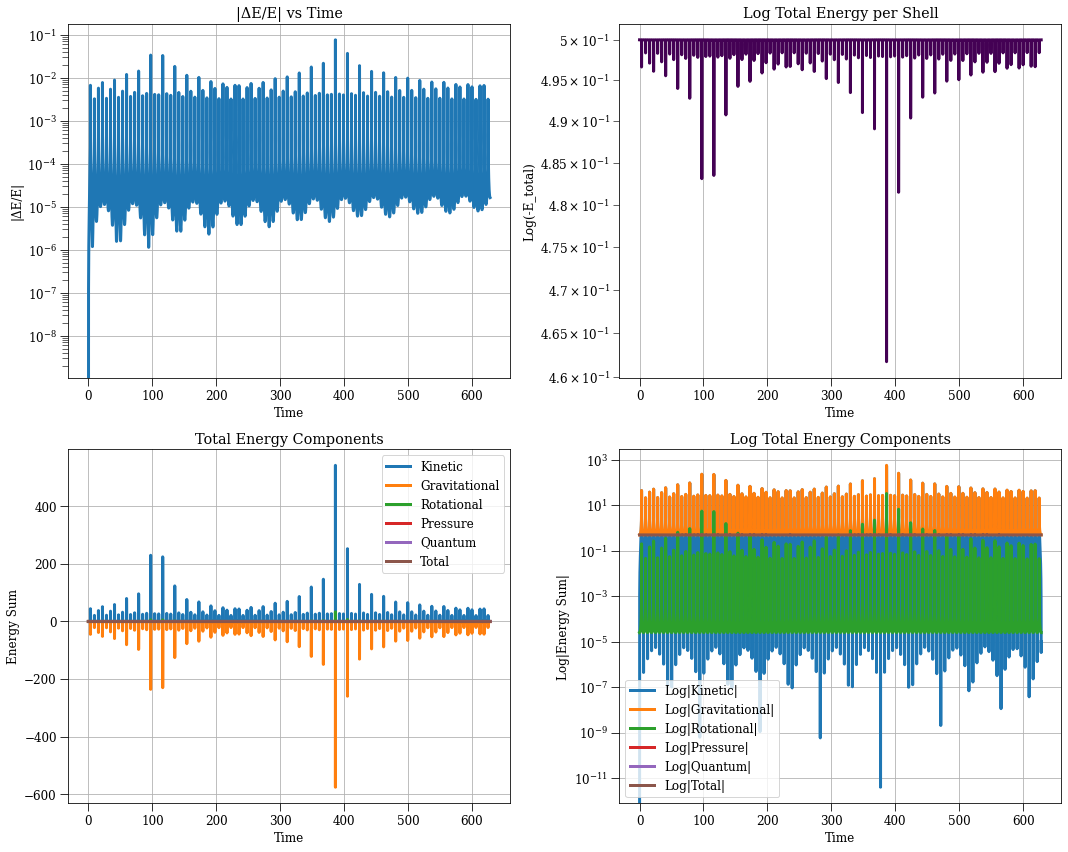

In [26]:
a = 1
e = 0.9999
r_max = a * (1+e)
r0 = r_max
v0 = 0
M = 1
safety_factor = 1e-2
j_coef = np.sqrt(1-e**2)
t_max = 200*np.pi


N = 1
save_dt = 1e-2
irs = 'equal_mass'
ivs = 'hubble'
density_strategy = 'const'
accel_strategy, ang_mom_strategy = 'soft_all', 'const'
energy_strategy = 'kin_grav_rot'
softlen = 0
hbar2_over_m2 = 0
problematic_shell_strategy = 'nothing'

tss = 'dyn_vel_acc'
mes = 'inclusive'
save_strategy = 'default'
r_min = 0
gamma = 0
thickness_coef = 0

config = make_config(N=N, r_min=r_min, r_max=r_max, t_max=t_max, j_coef=j_coef, save_dt=save_dt, density_strategy=density_strategy, safety_factor=safety_factor, stepper_strategy='leapfrog_hut',  timescale_strategy=tss, H=0, initial_radius_strategy=irs, gamma=gamma, initial_v_strategy=ivs, accel_strategy=accel_strategy, ang_mom_strategy=ang_mom_strategy, save_filename=f'thesis/kepler_symplectic-11-16-1.h5', r_small=1, softlen=softlen, problematic_shell_strategy=problematic_shell_strategy, thickness_coef=thickness_coef, m_enc_strategy=mes, save_strategy=save_strategy, hbar2_over_m2=hbar2_over_m2, energy_strategy=energy_strategy)
sc, results, plotter = run_sc(config, profile=False, plot=True);

2025-11-16 13:53:17,122 - collapse - INFO - Simulation setup complete


{'G': 1,
 'H': 0,
 'N': 1,
 'accel_strategy': 'soft_all',
 'ang_mom_strategy': 'const',
 'delta': 0,
 'density_strategy': 'const',
 'deque_size': 0,
 'drhodr_strategy': 'finite_diff',
 'dt': 1e-05,
 'dt_min': 0,
 'energy_strategy': 'kin_grav_rot',
 'gamma': 0,
 'hbar2_over_m2': 0,
 'initial_mass_strategy': 'integrated_mass',
 'initial_radius_strategy': 'equal_mass',
 'initial_v_strategy': 'hubble',
 'j_coef': 0.014141782065918275,
 'm_enc_strategy': 'inclusive',
 'm_pert': 1,
 'next_save_time': 0,
 'num_crossing': 0,
 'point_mass': 0,
 'point_mass_strategy': 'rmin_rho_r',
 'polytropic_coef': 0,
 'polytropic_index': -1,
 'pressure_strategy': 'zero',
 'problematic_shell_strategy': 'nothing',
 'r0_min': 1.9999,
 'r_max': 1.9999,
 'r_min': 0,
 'r_min_strategy': 'absorb',
 'r_small': 1,
 'r_ta_strategy': 'r_ta_cycloid',
 'relaxation_time': 0,
 'rho_bar': 0.05305164769729845,
 'safety_factor': 0.01,
 'save_dt': 0.01,
 'save_filename': 'thesis/kepler_not_symplectic-11-16-1.h5',
 'save_strateg

2025-11-16 13:53:28,634 - DEBUG - Saved dataset t with shape (38734,)
2025-11-16 13:53:28,638 - DEBUG - Saved dataset dt with shape (38734,)
2025-11-16 13:53:28,667 - DEBUG - Saved dataset r with shape (38734, 1)
2025-11-16 13:53:28,694 - DEBUG - Saved dataset v with shape (38734, 1)
2025-11-16 13:53:28,720 - DEBUG - Saved dataset a with shape (38734, 1)
2025-11-16 13:53:28,746 - DEBUG - Saved dataset m_enc with shape (38734, 1)
2025-11-16 13:53:28,771 - DEBUG - Saved dataset rho_r with shape (38734, 1)
2025-11-16 13:53:28,774 - WARNING - Skipping pressure because all values are None
2025-11-16 13:53:28,776 - WARNING - Skipping dpressure_drho because all values are None
2025-11-16 13:53:28,778 - WARNING - Skipping rho_prime because all values are None
2025-11-16 13:53:28,804 - DEBUG - Saved dataset e_tot with shape (38734, 1)
2025-11-16 13:53:28,825 - DEBUG - Saved dataset e_g with shape (38734, 1)
2025-11-16 13:53:28,846 - DEBUG - Saved dataset e_k with shape (38734, 1)
2025-11-16 13:

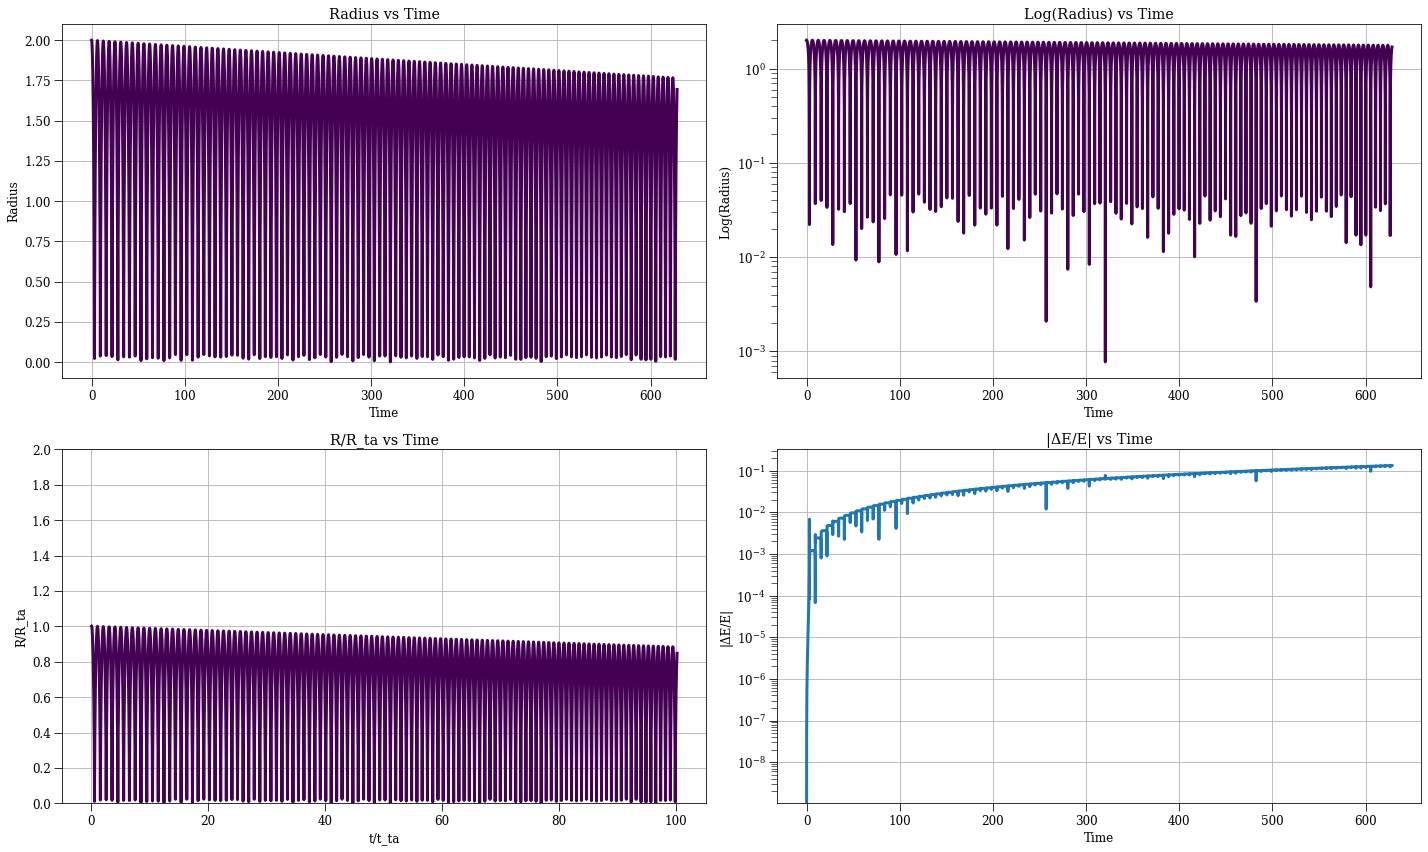

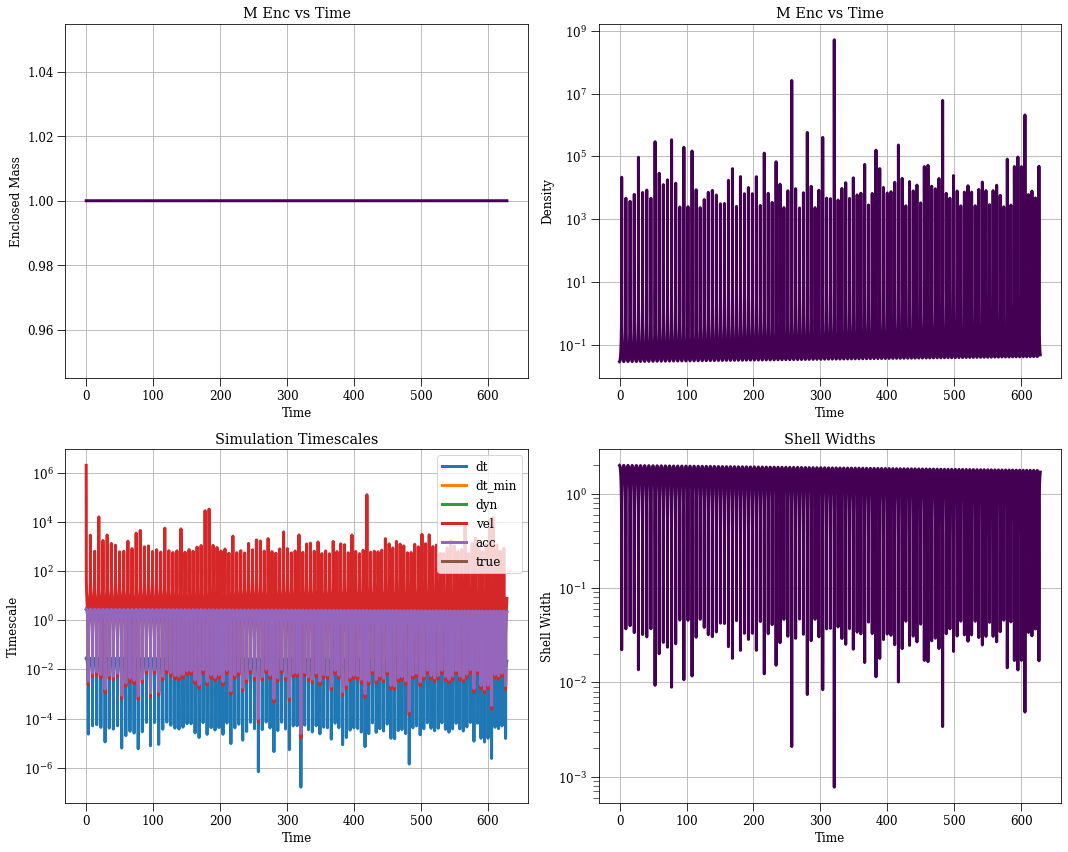

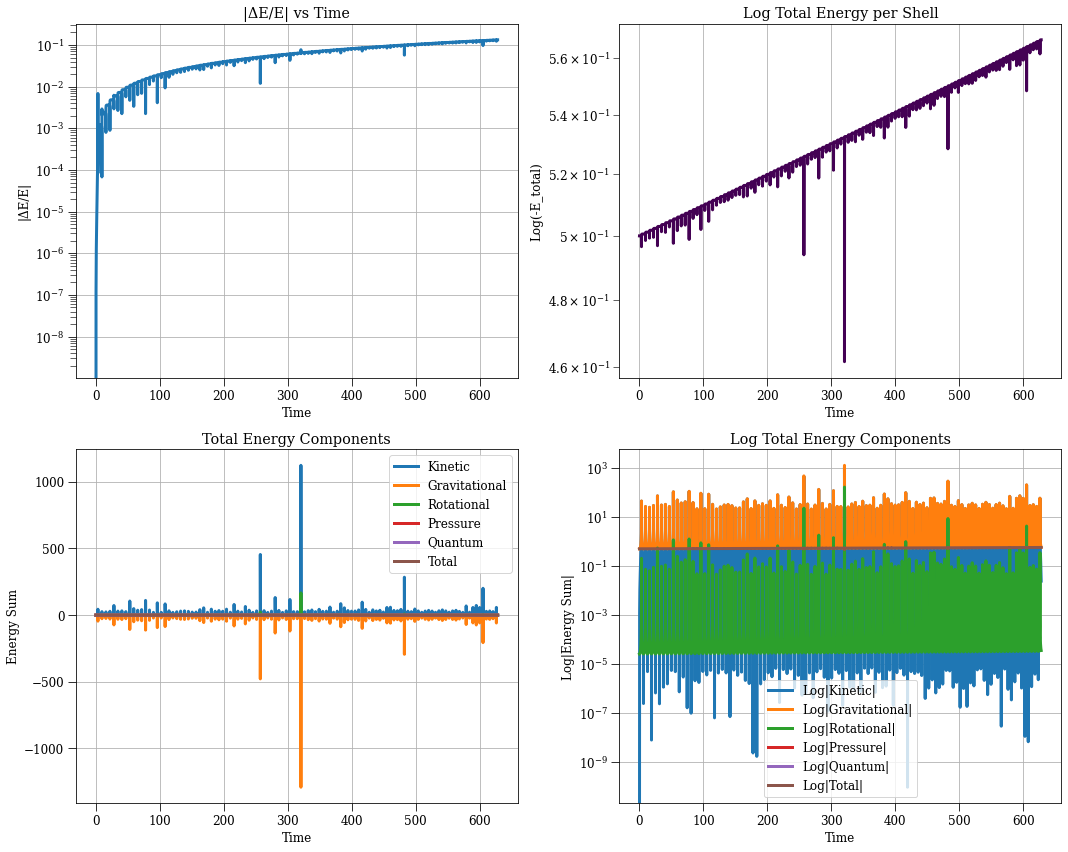

In [37]:
a = 1
e = 0.9999
r_max = a * (1+e)
r0 = r_max
v0 = 0
M = 1
safety_factor = 1e-2
j_coef = np.sqrt(1-e**2)
t_max = 200*np.pi


N = 1
save_dt = 1e-2
irs = 'equal_mass'
ivs = 'hubble'
density_strategy = 'const'
accel_strategy, ang_mom_strategy = 'soft_all', 'const'
energy_strategy = 'kin_grav_rot'
softlen = 0
hbar2_over_m2 = 0
problematic_shell_strategy = 'nothing'

tss = 'dyn_vel_acc'
mes = 'inclusive'
save_strategy = 'default'
r_min = 0
gamma = 0
thickness_coef = 0

config = make_config(N=N, r_min=r_min, r_max=r_max, t_max=t_max, j_coef=j_coef, save_dt=save_dt, density_strategy=density_strategy, safety_factor=safety_factor, stepper_strategy='leapfrog_kdk',  timescale_strategy=tss, H=0, initial_radius_strategy=irs, gamma=gamma, initial_v_strategy=ivs, accel_strategy=accel_strategy, ang_mom_strategy=ang_mom_strategy, save_filename=f'thesis/kepler_not_symplectic-11-16-1.h5', r_small=1, softlen=softlen, problematic_shell_strategy=problematic_shell_strategy, thickness_coef=thickness_coef, m_enc_strategy=mes, save_strategy=save_strategy, hbar2_over_m2=hbar2_over_m2, energy_strategy=energy_strategy)
sc, results, plotter = run_sc(config, profile=False, plot=True);

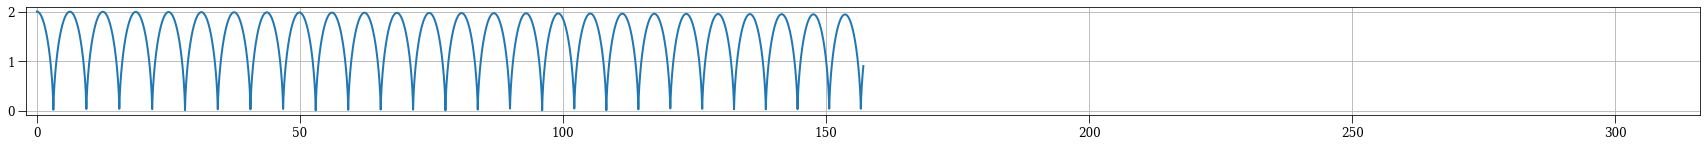

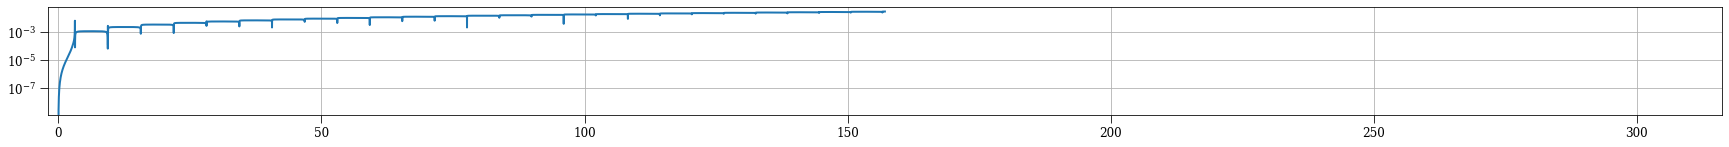

In [36]:
params, results = load_simulation_data('thesis/kepler_not_symplectic-11-16-1.h5')
params2, results2 = load_simulation_data('thesis/kepler_symplectic-11-16-1.h5')
r = results['r'][:,0]
t = results['t']
dele_on_e = (results['e_tot'][:,0]-results['e_tot'][:,0][0]) / results['e_tot'][:,0][0]
plt.figure(figsize=(30, 2))
plt.plot(t, r, lw=2)
edge = 2
plt.xlim(-edge, 100*np.pi + edge)
plt.figure(figsize=(30, 2))
plt.plot(t, np.abs(dele_on_e), lw=2)
edge = 2
plt.xlim(-edge, 100*np.pi + edge)
plt.yscale('log')

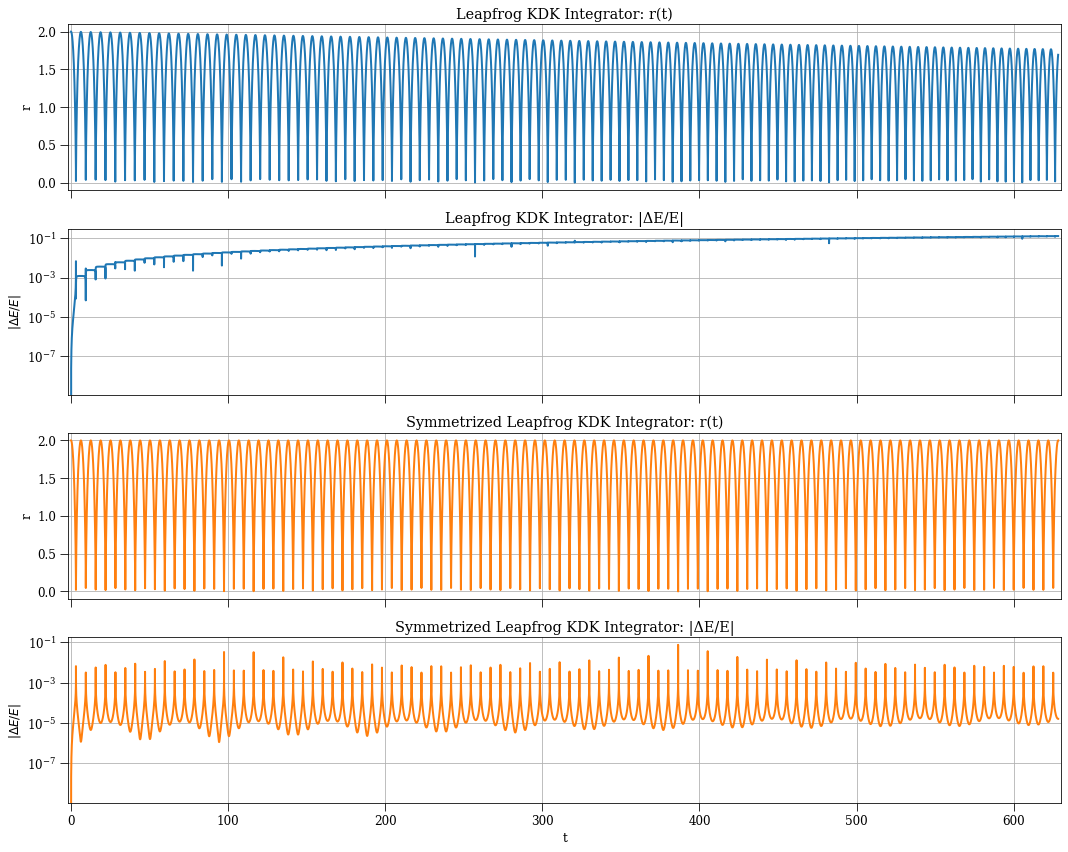

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Load both runs
params1, results1 = load_simulation_data('thesis/kepler_not_symplectic-11-16-1.h5')
params2, results2 = load_simulation_data('thesis/kepler_symplectic-11-16-1.h5')

# Extract (first shell/particle)
t1 = np.asarray(results1['t'])
r1 = np.asarray(results1['r'])[:, 0]
e1 = np.asarray(results1['e_tot'])[:, 0]
dE_over_E1 = (e1 - e1[0]) / e1[0]

t2 = np.asarray(results2['t'])
r2 = np.asarray(results2['r'])[:, 0]
e2 = np.asarray(results2['e_tot'])[:, 0]
dE_over_E2 = (e2 - e2[0]) / e2[0]

# Common x-limits
edge = 2
xmax = 200*np.pi + edge

# Stacked 4 panels, each ~ (30,2) tall => total (30,8)
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
(ax_r1, ax_e1, ax_r2, ax_e2) = axes

# --- First file ---
ax_r1.plot(t1, r1, lw=2)
ax_r1.set_ylabel('r')
ax_r1.set_title('Leapfrog KDK Integrator: r(t)')
ax_r1.grid(True, alpha=1)

ax_e1.plot(t1, np.abs(dE_over_E1), lw=2)
ax_e1.set_yscale('log')
ax_e1.set_ylabel(r'$|\Delta E/E|$')
ax_e1.set_title('Leapfrog KDK Integrator: |ΔE/E|')
ax_e1.grid(True, alpha=1)

# --- Second file (C1) ---
ax_r2.plot(t2, r2, lw=2, color='C1')
ax_r2.set_ylabel('r')
ax_r2.set_title('Symmetrized Leapfrog KDK Integrator: r(t)')
ax_r2.grid(True, alpha=1)

ax_e2.plot(t2, np.abs(dE_over_E2), lw=2, color='C1')
ax_e2.set_yscale('log')
ax_e2.set_ylabel(r'$|\Delta E/E|$')
ax_e2.set_title('Symmetrized Leapfrog KDK Integrator: |ΔE/E|')
ax_e2.grid(True, alpha=1)

# Common x-axis on the bottom only
for ax in axes:
    ax.set_xlim(-edge, xmax)
axes[-1].set_xlabel('t')

fig.tight_layout()
plt.savefig('thesis/symplectic.pdf')


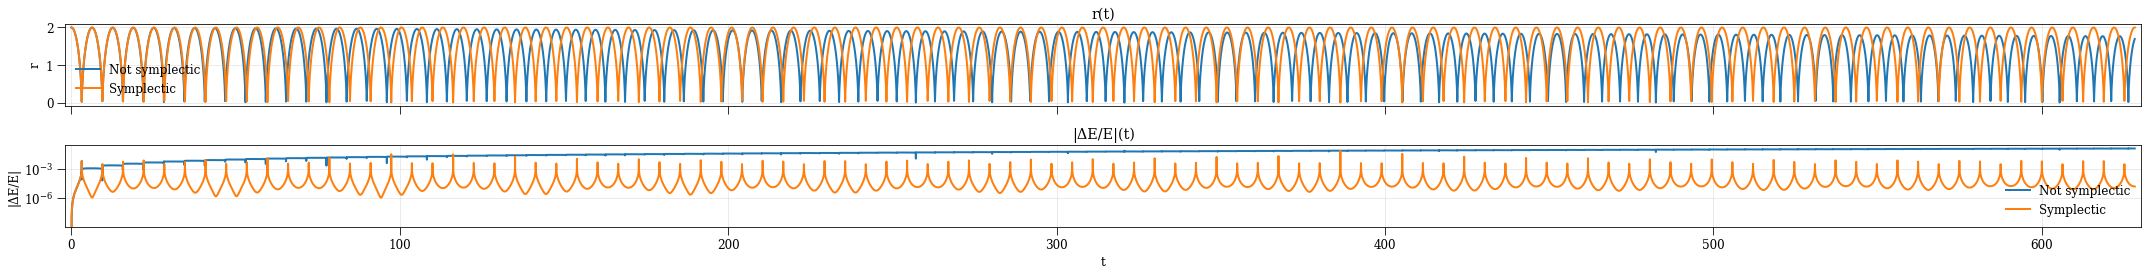

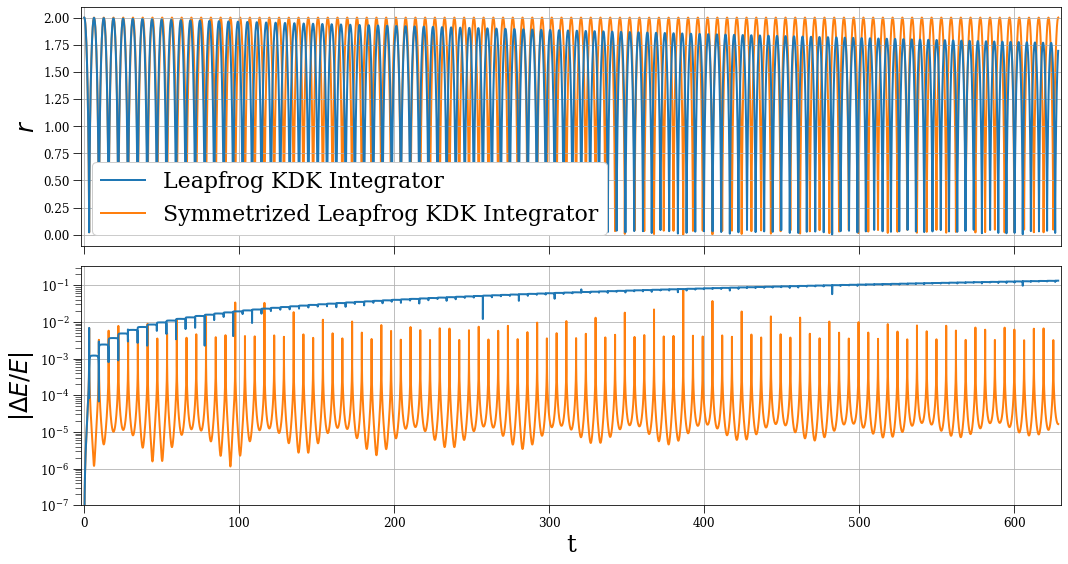

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Load both runs
params1, results1 = load_simulation_data('thesis/kepler_not_symplectic-11-16-1.h5')
params2, results2 = load_simulation_data('thesis/kepler_symplectic-11-16-1.h5')

# Extract (first shell/particle)
t1 = np.asarray(results1['t'])
r1 = np.asarray(results1['r'])[:, 0]
e1 = np.asarray(results1['e_tot'])[:, 0]
dE_over_E1 = (e1 - e1[0]) / e1[0]

t2 = np.asarray(results2['t'])
r2 = np.asarray(results2['r'])[:, 0]
e2 = np.asarray(results2['e_tot'])[:, 0]
dE_over_E2 = (e2 - e2[0]) / e2[0]

# Common x-limits
edge = 2
xmax = 200*np.pi + edge

# Stacked 4 panels, each ~ (30,2) tall => total (30,8)
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
(ax_r1, ax_e1) = axes

# --- First file ---
fs = 24
ax_r1.plot(t1, r1, lw=2, label='Leapfrog KDK Integrator', color='C0')
ax_r1.plot(t2, r2, lw=2, label='Symmetrized Leapfrog KDK Integrator', color='C1', zorder=-99)
ax_r1.legend(fontsize=fs-2, framealpha=1)

ax_r1.set_ylabel(f'$r$', fontsize=fs)
#ax_r1.set_title('Leapfrog KDK Integrator: r(t)')
ax_r1.grid(True, alpha=1)

ax_e1.plot(t2, np.abs(dE_over_E2), lw=2, color='C1')
ax_e1.plot(t1, np.abs(dE_over_E1), lw=2, alpha=1)
ax_e1.set_yscale('log')
ax_e1.set_ylabel(r'$|\Delta E/E|$', fontsize=fs)
#ax_e1.set_title('Leapfrog KDK Integrator: |ΔE/E|')
ax_e1.grid(True, alpha=1)
ax_e1.set_ylim(1e-7, None)

# # --- Second file (C1) ---
# ax_r2.plot(t2, r2, lw=2, color='C1')
# ax_r2.set_ylabel('r')
# ax_r2.set_title('Symmetrized Leapfrog KDK Integrator: r(t)')
# ax_r2.grid(True, alpha=1)

# ax_e2.plot(t2, np.abs(dE_over_E2), lw=2, color='C1')
# ax_e2.set_yscale('log')
# ax_e2.set_ylabel(r'$|\Delta E/E|$')
# ax_e2.set_title('Symmetrized Leapfrog KDK Integrator: |ΔE/E|')
# ax_e2.grid(True, alpha=1)

# Common x-axis on the bottom only
for ax in axes:
    ax.set_xlim(-edge, xmax)
axes[-1].set_xlabel('t', fontsize=fs)

fig.tight_layout()
plt.savefig('thesis/symplectic2.pdf')


### Multishell Top Hat

2025-11-16 16:15:45,598 - collapse - INFO - Simulation setup complete


{'G': 1,
 'H': 0.6666666666666666,
 'N': 50,
 'accel_strategy': 'soft_all',
 'ang_mom_strategy': 'const',
 'delta': 0.001,
 'density_strategy': 'background_plus_tophat2',
 'deque_size': 0,
 'drhodr_strategy': 'finite_diff',
 'dt': 1e-05,
 'dt_min': 0,
 'energy_strategy': 'kin_grav_rot_absorbed',
 'gamma': 0,
 'hbar2_over_m2': 0,
 'initial_mass_strategy': 'integrated_mass',
 'initial_radius_strategy': 'equal_mass',
 'initial_v_strategy': 'hubble',
 'j_coef': 0,
 'm_enc_strategy': 'inclusive',
 'm_pert': 1,
 'next_save_time': 0,
 'num_crossing': 0,
 'point_mass': 0,
 'point_mass_strategy': 'manual',
 'polytropic_coef': 0,
 'polytropic_index': -1,
 'pressure_strategy': 'zero',
 'problematic_shell_strategy': 'nothing',
 'r0_min': 0.0200098,
 'r_max': 1,
 'r_min': 1e-05,
 'r_min_strategy': 'absorb',
 'r_small': 1,
 'r_ta_strategy': 'r_ta_cycloid',
 'relaxation_time': 0,
 'rho_bar': 0.05305164769729845,
 'safety_factor': 0.001,
 'save_dt': 10,
 'save_filename': 'thesis/tophat.h5',
 'save_str

/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/src/simulation_strategies.py:521: RuntimeWarning: divide by zero encountered in true_divide
  return sim.m / volumes
2025-11-16 16:16:31,790 - DEBUG - Saved dataset t with shape (11230,)
2025-11-16 16:16:31,792 - DEBUG - Saved dataset dt with shape (11230,)
2025-11-16 16:16:31,807 - DEBUG - Saved dataset r with shape (11230, 50)
2025-11-16 16:16:31,818 - DEBUG - Saved dataset v with shape (11230, 50)
2025-11-16 16:16:31,830 - DEBUG - Saved dataset a with shape (11230, 50)
2025-11-16 16:16:31,840 - DEBUG - Saved dataset m_enc with shape (11230, 50)
2025-11-16 16:16:31,851 - DEBUG - Saved dataset rho_r with shape (11230, 50)
2025-11-16 16:16:31,853 - WARNING - Skipping pressure because all values are None
2025-11-16 16:16:31,854 - WARNING - Skipping dpressure_drho because all values are None
2025-11-16 16:16:31,857 - WARNING - Skipping rho_prime because all values are None
2025-11-16 16:16:31,874 - DEBUG

2025-11-16 16:16:31,898 - DEBUG - Saved dataset e_k with shape (11230, 50)
2025-11-16 16:16:31,909 - DEBUG - Saved dataset e_r with shape (11230, 50)
2025-11-16 16:16:31,911 - WARNING - Skipping e_p because all values are None
2025-11-16 16:16:31,912 - WARNING - Skipping e_q because all values are None
2025-11-16 16:16:31,914 - DEBUG - Saved dataset t_dyn with shape (11230,)
2025-11-16 16:16:31,916 - DEBUG - Saved dataset t_vel with shape (11230,)
2025-11-16 16:16:31,917 - DEBUG - Saved dataset t_acc with shape (11230,)
2025-11-16 16:16:31,919 - WARNING - Skipping t_cross because all values are None
2025-11-16 16:16:31,920 - WARNING - Skipping t_crossa because all values are None
2025-11-16 16:16:31,921 - WARNING - Skipping t_cross2 because all values are None
2025-11-16 16:16:31,922 - WARNING - Skipping t_zero because all values are None
2025-11-16 16:16:31,924 - WARNING - Skipping t_rmin because all values are None
2025-11-16 16:16:31,925 - WARNING - Skipping t_rmina because all valu

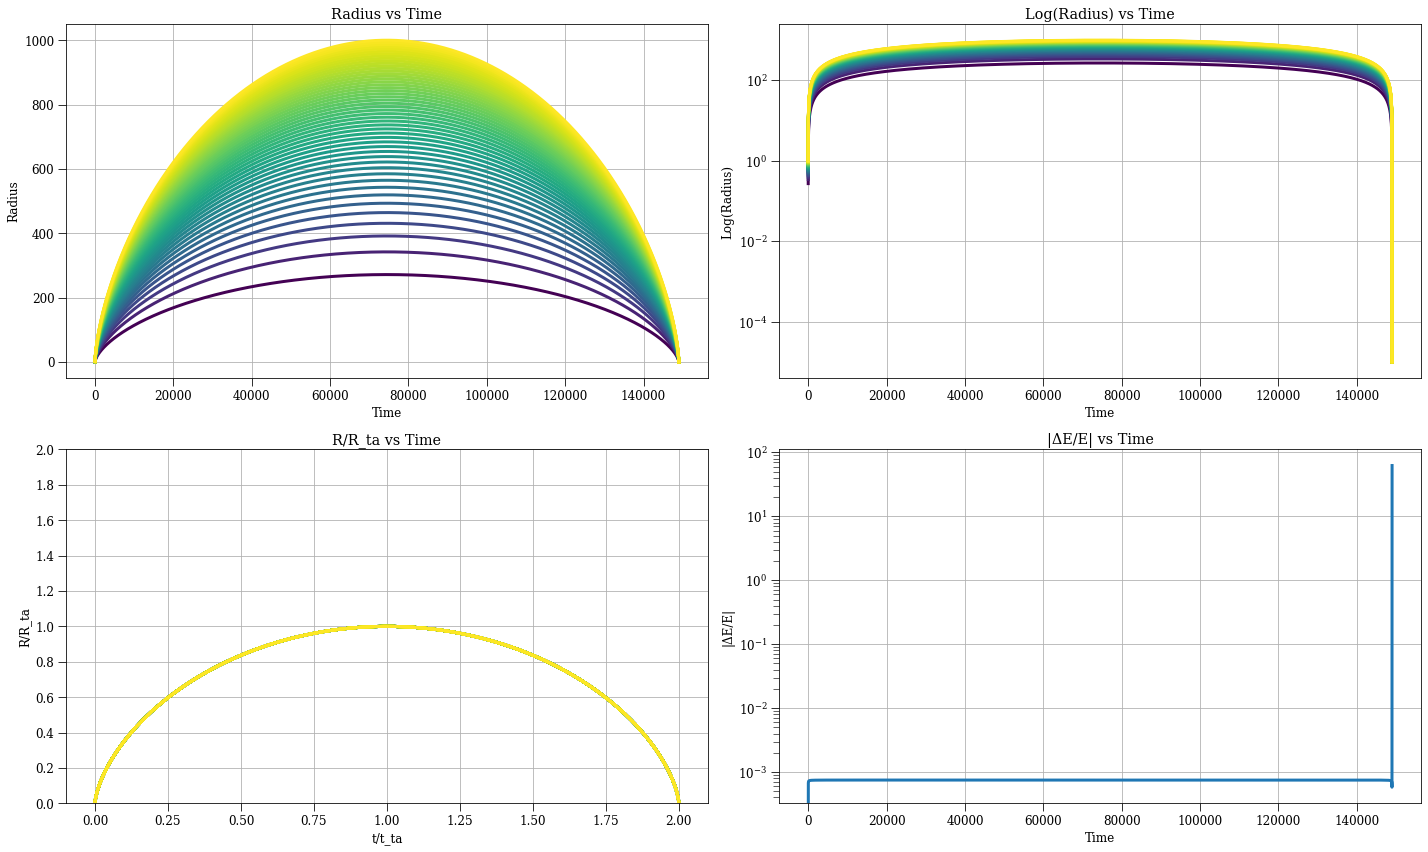

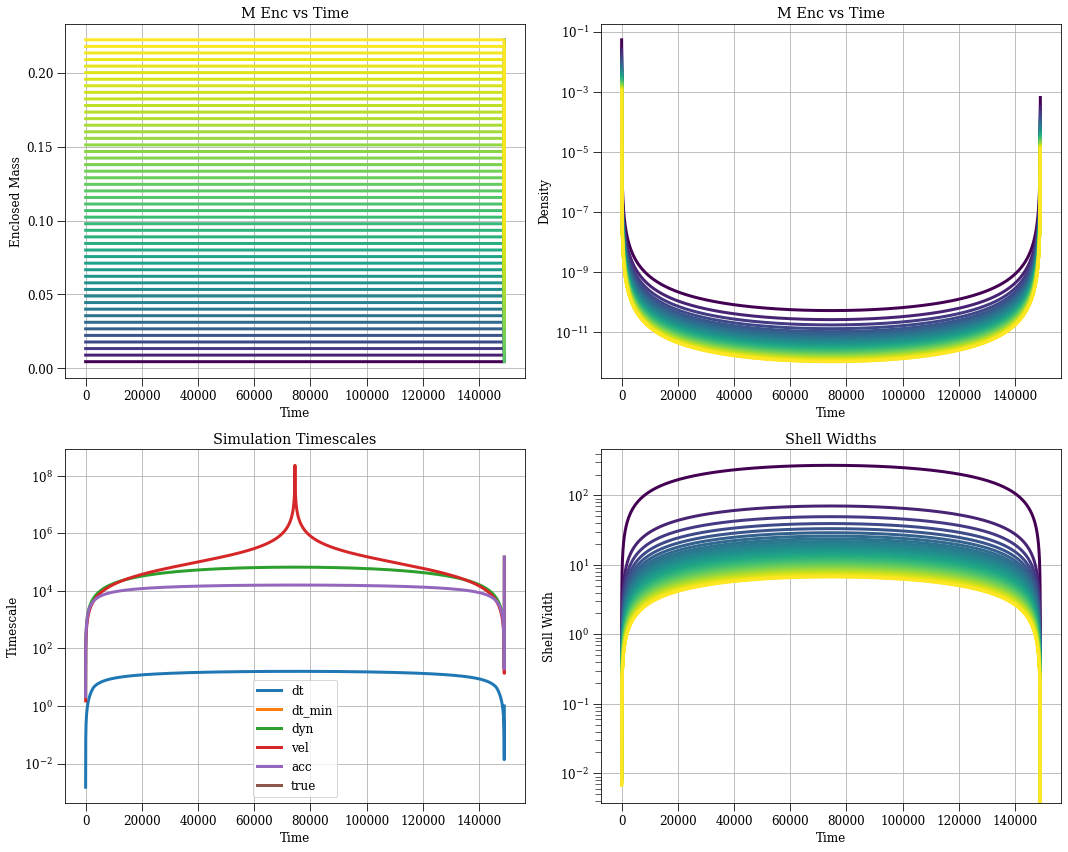

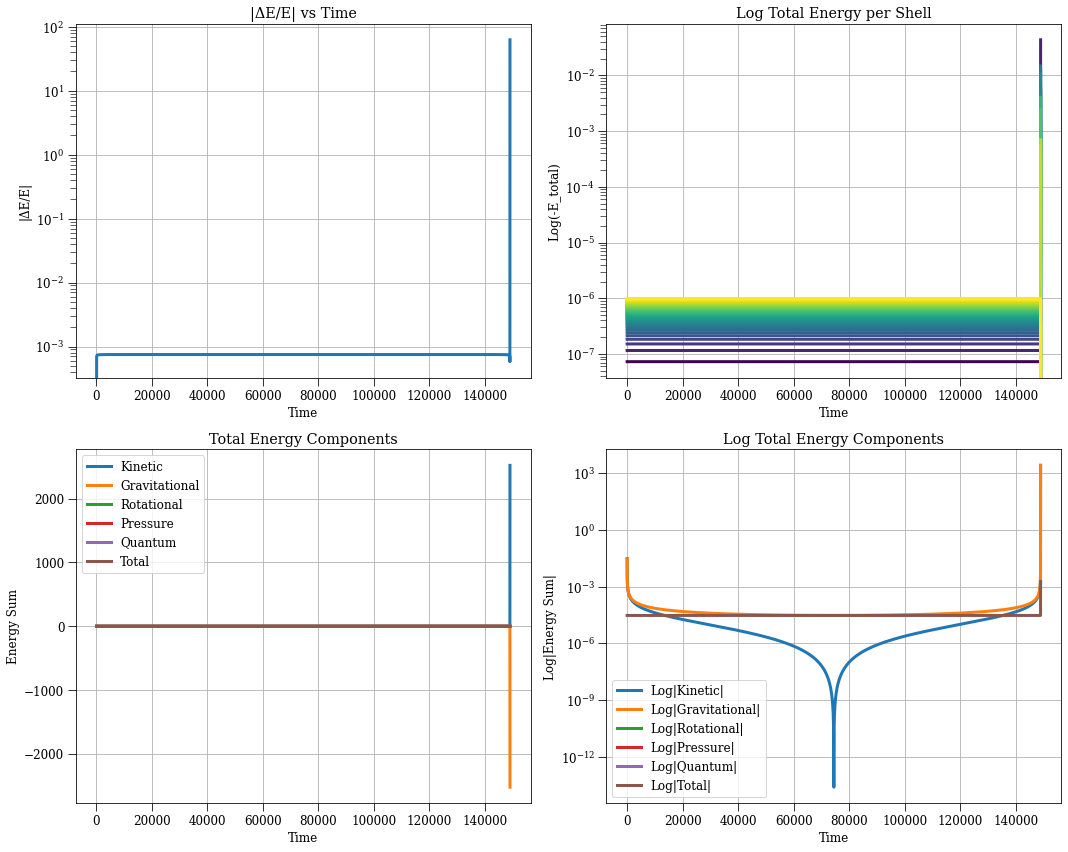

In [196]:
r_max = 1
j_coef = 0
N = 50
t_max =  3/2 * np.pi * (1e-3)**(-3/2) - 1
safety_factor = 1e-3
save_dt = 10
delta = 1e-3
irs = 'equal_mass'
ivs = 'hubble'
density_strategy = 'background_plus_tophat2'
accel_strategy, ang_mom_strategy = 'soft_all', 'const' #'fdm4', 'const' 
energy_strategy = 'kin_grav_rot_absorbed'
softlen = 0
hbar2_over_m2 = 0
problematic_shell_strategy = 'nothing'
tophat_radius = 1
point_mass =  0#4/3 * np.pi * tophat_radius**3 * (1 + 1e-3) * rho_H

tss = 'dyn_vel_acc'
mes = 'inclusive'
save_strategy = 'default'
r_min = 1e-5
gamma = 0
thickness_coef = 0

config = make_config(N=N, r_min=r_min, r_max=r_max, t_max=t_max, j_coef=j_coef, save_dt=save_dt, density_strategy=density_strategy, safety_factor=safety_factor, stepper_strategy='leapfrog_hut',  timescale_strategy=tss, H=H0, initial_radius_strategy=irs, gamma=gamma, initial_v_strategy=ivs, accel_strategy=accel_strategy, ang_mom_strategy=ang_mom_strategy, save_filename=f'thesis/tophat.h5', r_small=1, softlen=softlen, problematic_shell_strategy=problematic_shell_strategy, thickness_coef=thickness_coef, m_enc_strategy=mes, save_strategy=save_strategy, hbar2_over_m2=hbar2_over_m2, energy_strategy=energy_strategy, r_min_strategy='absorb', tophat_radius=tophat_radius, point_mass=point_mass, point_mass_strategy='manual', delta=delta)
sc, results, plotter = run_sc(config, profile=False, plot=True);

In [ ]:
params, results = load_simulation_data('thesis/tophat.h5')
print(len(results['r'][0]))

for i in range(params['N']):
    pass

50


In [189]:
print(results['m'][0], sc.point_mass,results['m_enc'][0], 4/3 * np.pi * 1**3 * (1 + 1e-3) * rho_H, 4/3 * np.pi * 1**3 * rho_H)

[0.] 0.22244444444444442 [0.22244444] 0.22244444444444442 0.2222222222222222


In [194]:
print(results['m'][0], sc.point_mass,results['m_enc'][0], 4/3 * np.pi * 1**3 * (1 + 1e-3) * rho_H, 4/3 * np.pi * 1**3 * rho_H)

[0.22244449] 0 [0.22244449] 0.22244444444444442 0.2222222222222222


### Black Hole Case

In [155]:
r_max = 2
j_coef = 0
N = 100
t_max = 20 *3/2 * np.pi * (1e-3)**(-3/2) - 1
safety_factor = 1e-3
save_dt = 10
delta = 0
irs = 'equal_mass'
ivs = 'hubble'
density_strategy = 'background_plus_tophat2'
accel_strategy, ang_mom_strategy = 'soft_all', 'const' #'fdm4', 'const' 
energy_strategy = 'kin_grav_rot_absorbed'
softlen = 0
hbar2_over_m2 = 0
problematic_shell_strategy = 'nothing'
tophat_radius = 1
point_mass = 4/3 * np.pi * tophat_radius**3 * (1 + 1e-3) * rho_H

tss = 'dyn_vel_acc'
mes = 'inclusive'
save_strategy = 'default'
r_min = 1
gamma = 0
thickness_coef = 0

config = make_config(N=N, r_min=r_min, r_max=r_max, t_max=t_max, j_coef=j_coef, save_dt=save_dt, density_strategy=density_strategy, safety_factor=safety_factor, stepper_strategy='leapfrog_hut',  timescale_strategy=tss, H=H0, initial_radius_strategy=irs, gamma=gamma, initial_v_strategy=ivs, accel_strategy=accel_strategy, ang_mom_strategy=ang_mom_strategy, save_filename=f'thesis/black_hole.h5', r_small=1, softlen=softlen, problematic_shell_strategy=problematic_shell_strategy, thickness_coef=thickness_coef, m_enc_strategy=mes, save_strategy=save_strategy, hbar2_over_m2=hbar2_over_m2, energy_strategy=energy_strategy, r_min_strategy='absorb', tophat_radius=tophat_radius, point_mass=point_mass, point_mass_strategy='manual')
sc, results, plotter = run_sc(config, profile=False, plot=True);

{'G': 1,
 'H': 0.6666666666666666,
 'N': 100,
 'accel_strategy': 'soft_all',
 'ang_mom_strategy': 'const',
 'delta': 0,
 'density_strategy': 'background_plus_tophat2',
 'deque_size': 0,
 'drhodr_strategy': 'finite_diff',
 'dt': 1e-05,
 'dt_min': 0,
 'energy_strategy': 'kin_grav_rot_absorbed',
 'gamma': 0,
 'hbar2_over_m2': 0,
 'initial_mass_strategy': 'integrated_mass',
 'initial_radius_strategy': 'equal_mass',
 'initial_v_strategy': 'hubble',
 'j_coef': 0,
 'm_enc_strategy': 'inclusive',
 'm_pert': 1,
 'next_save_time': 0,
 'num_crossing': 0,
 'point_mass': 0.22244444444444442,
 'point_mass_strategy': 'manual',
 'polytropic_coef': 0,
 'polytropic_index': -1,
 'pressure_strategy': 'zero',
 'problematic_shell_strategy': 'nothing',
 'r0_min': 1.01,
 'r_max': 2,
 'r_min': 1,
 'r_min_strategy': 'absorb',
 'r_small': 1,
 'r_ta_strategy': 'r_ta_cycloid',
 'relaxation_time': 0,
 'rho_bar': 0.05305164769729845,
 'safety_factor': 0.001,
 'save_dt': 10,
 'save_filename': 'thesis/black_hole.h5',


2025-11-16 15:35:42,337 - collapse - INFO - Simulation setup complete


/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/src/simulation_strategies.py:521: RuntimeWarning: divide by zero encountered in true_divide
  return sim.m / volumes


2025-11-16 15:37:33,476 - DEBUG - Saved dataset t with shape (167607,)
2025-11-16 15:37:33,495 - DEBUG - Saved dataset dt with shape (167607,)
2025-11-16 15:37:33,806 - DEBUG - Saved dataset r with shape (167607, 100)
2025-11-16 15:37:34,089 - DEBUG - Saved dataset v with shape (167607, 100)
2025-11-16 15:37:34,357 - DEBUG - Saved dataset a with shape (167607, 100)
2025-11-16 15:37:34,622 - DEBUG - Saved dataset m_enc with shape (167607, 100)
2025-11-16 15:37:34,891 - DEBUG - Saved dataset rho_r with shape (167607, 100)
2025-11-16 15:37:34,899 - WARNING - Skipping pressure because all values are None
2025-11-16 15:37:34,908 - WARNING - Skipping dpressure_drho because all values are None
2025-11-16 15:37:34,916 - WARNING - Skipping rho_prime because all values are None
2025-11-16 15:37:35,116 - DEBUG - Saved dataset e_tot with shape (167607, 100)
2025-11-16 15:37:35,312 - DEBUG - Saved dataset e_g with shape (167607, 100)
2025-11-16 15:37:35,498 - DEBUG - Saved dataset e_k with shape (1

KeyboardInterrupt: 

In [145]:
results['m'][0]

array([0.])

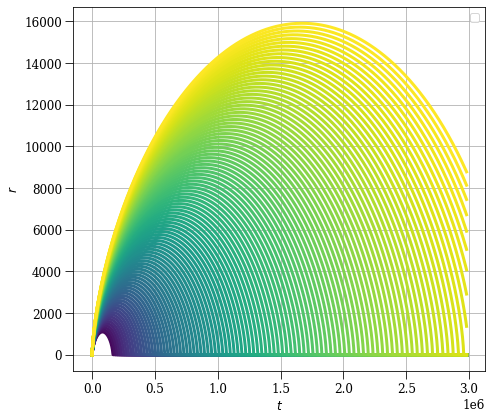

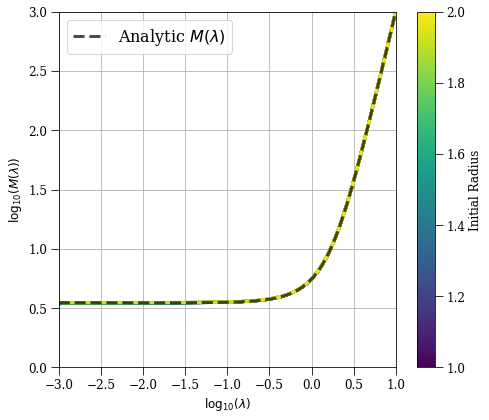

In [207]:
t_i = 1
G = 1
rho_H = 1/(6*np.pi*G*t_i**2)
theta_vals = np.linspace(0, 2*np.pi, 1000)

def delta_m(m_pert):
    return m_pert / (4*np.pi*rho_H)
def lambda_theta(theta):
    # Add small epsilon to avoid division by zero
    eps = 1e-10
    return 0.5*(1-np.cos(theta))*((theta-np.sin(theta) + eps)/np.pi)**(-8/9)
# Create theta_vals and corresponding lambda_vals
theta_vals = np.linspace(1e-6, 2*np.pi, 1000)
lambda_vals = lambda_theta(theta_vals)

# Create the inverse mapping (lambda -> theta)
theta_lambda = interp1d(lambda_vals, theta_vals, bounds_error=False, fill_value=np.nan)
def r_ta(r_i, m_pert):
    return r_i**4 / (3*delta_m(m_pert))
def t_ta(r_i, m_pert, H):
    return np.pi*r_i**(9/2) / (6*np.sqrt(3)*H*delta_m(m_pert)**(3/2))
def r_theta(r_i, m_pert, theta):
    return r_ta(r_i, m_pert)/2 * (1-np.cos(theta))
def t_theta(r_i, m_pert, H, theta):
    return t_ta(r_i, m_pert, H)/np.pi * (theta-np.sin(theta))
def theta_t(r_i, m_pert, H, t):
    return interp1d(theta_vals, t_theta(r_i, m_pert, H, theta_vals), fill_value=0)(t)
def v_lambda(lam):
    theta = theta_lambda(lam)
    return lam * (np.sin(theta)*(theta-np.sin(theta)))/(1-np.cos(theta))**2
def tau(t, t_i):
    return t_i + t/t_i
def shifted_t(t, t_i):
    return t + t_i
def r_cta(t, m_pert, H):
    return (1/3)*(6*np.sqrt(3)*H/np.pi)**(8/9) * delta_m(m_pert)**(1/3) * (shifted_t(t, t_i))**(8/9)
def lambda_rt(r, t, m_pert, H):
    return r / r_cta(t, m_pert, H)
def m_lambda(lam, H):
    theta = theta_lambda(lam)
    return lam**3 * (2/H**2) * (theta-np.sin(theta))**2/(1-np.cos(theta))**3
def d_lambda(lam, H):
    return m_lambda(lam, H)/lam**3 * 1/(4-(9/2)*v_lambda(lam)/lam)
def rho_H_t(t):
    return rho_H * (1+t/t_i)**(-2)
def m_from_results(t, m_enc, m_pert, H):
    return m_enc / (4/3 * np.pi * rho_H_t(t) * r_cta(t, m_pert, H)**3)
def d_from_results(t, m_shell, r_shell, r_prev_shell):
    vol_shell = 4/3 * np.pi * (r_shell**3 - r_prev_shell**3)
    return (m_shell/vol_shell) / rho_H_t(t)

cmap = plt.cm.viridis
file = 'thesis/black_hole.h5'
file_path = 'thesis/black_hole.h5'
try:
    # Load the simulation data
    params, results = load_simulation_data(file_path)
    tophat_radius = 1
    m_pert = 4/3 * np.pi * tophat_radius**3 * 1e-3 * rho_H
    H = 2/3
    G = 1
    N = params['N']

    # Extract initial radii
    initial_radii = results['r'][0, :]  # First time step for all shells
    r_min, r_max = initial_radii.min(), initial_radii.max()

    # Define normalization based on initial radii
    norm = plt.Normalize(1, 2)

    # Plot all shells with color based on initial radii
    plt.figure(figsize=(7, 6))
    for idx in range(N):
        t, r = results['t'], results['r'][:, idx]
        r_initial = initial_radii[idx]
        plt.plot(t, r, color=cmap(norm(r_initial)), alpha=1)

    # Create ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # cbar = plt.colorbar(sm, label='Initial Radius')
    #cbar.set_ticks([1, 1.2, 1.4, 1.6, 1.8, 2])

    # Handle legend to avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r$')
    plt.tight_layout()
    plt.savefig('thesis/black_hole_traj.pdf')

    # --- Second Plot: log10(lambda) vs log10(m_coord) ---
    plt.figure(figsize=(7, 6))
    # plt.title("Trajectories that start outside of the perturbation")
    plt.xlabel(r'$\log_{10}(\lambda)$')
    plt.ylabel(r'$\log_{10}(M(\lambda))$')

    for idx in range(N):
        t, r, v, m_enc = results['t'], results['r'][:, idx], results['v'][:, idx], results['m_enc'][:, idx]
        r_initial = initial_radii[idx]
        if r[0] >= tophat_radius:
            lambda_coord = lambda_rt(r, t, m_pert, H)
            m_coord = m_from_results(t, m_enc, m_pert, H)
            plt.plot(np.log10(lambda_coord), np.log10(m_coord), color=cmap(norm(r_initial)), alpha=0.2, lw=3)
            #plt.plot(lambda_coord, m_coord, color=cmap(norm(r_initial)), alpha=0.2)

    # Plot the analytic curve
    lambda_vals = np.linspace(1e-3, 10, 1000)
    plt.plot(np.log10(lambda_vals), np.log10(m_lambda(lambda_vals, H)), ls='--', color='k', label=r'Analytic $M(\lambda)$', alpha=0.7, lw=3)
    #plt.plot(lambda_vals, m_lambda(lambda_vals, H), ls='--', color='k', label=r'$M(\lambda)$ Black Hole Case')

    # Create ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Initial Radius')
    #cbar.set_ticks([1, 1.2, 1.4, 1.6, 1.8, 2])
    #cbar.set_ticklabels([f'{r_min:.2f}', f'{1:.2f}', f'{r_max:.2f}'])

    # Handle legend to avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize=16)

    plt.xlim(-3, 1)
    plt.ylim(0, 3)
    plt.tight_layout()
    plt.savefig('thesis/black_hole_menc.pdf')
    # plt.figure()

    # lambda_vals = np.linspace(1e-4, 3, 1000)
    # for idx in range(N):
    #     t, r, v = results['t'], results['r'][:, idx], results['v'][:, idx]
    #     r_initial = r[0]
    #     if r[0] >= tophat_radius:
    #         lambda_coord = lambda_rt(r, t, m_pert, H)
    #         v_coord = v * shifted_t(t, t_i) / r_cta(t, m_pert, H)
    #         dlam_dxi = v_coord + (8/9)*lambda_coord
    #         plt.plot(np.log10(lambda_coord), dlam_dxi, label=f'Shell {idx+1}', color=cmap(norm(r_initial)), alpha=0.2)
    #         #plt.plot(lambda_coord, dlam_dxi, label=f'Shell {idx+1}', color=cmap(norm(r_initial)), alpha=0.2)
    # plt.plot(np.log10(lambda_vals), v_lambda(lambda_vals) + (8/9)*lambda_vals, ls='--', color='k', label=r'$\frac{d\lambda}{d\xi}$ Black Hole Case')
    # #plt.plot(lambda_vals, v_lambda(lambda_vals) + (8/9)*lambda_vals, ls='--', color='k', label=r'$\frac{d\lambda}{d\xi}$ Black Hole Case')
    # plt.xlabel(r'$\log_{10}(\lambda)$')
    # plt.ylabel(r'$\frac{d\lambda}{d\xi} = V(\lambda) + \frac{8}{9}\lambda$')
    # plt.ylim(-10, 10)
    # plt.xlim(-2, None)

    # # Create ScalarMappable for the colorbar
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    # cbar = plt.colorbar(sm, label='Initial Radius')
    # cbar.set_ticks([r_min, 1, r_max])
    # cbar.set_ticklabels([f'{r_min:.2f}', f'{1:.2f}', f'{r_max:.2f}'])
    # plt.tight_layout()
    
    # plt.figure(figsize=(7, 6))

except Exception as e:
    print(f"Error processing {file_path}: {e}")

### fdm

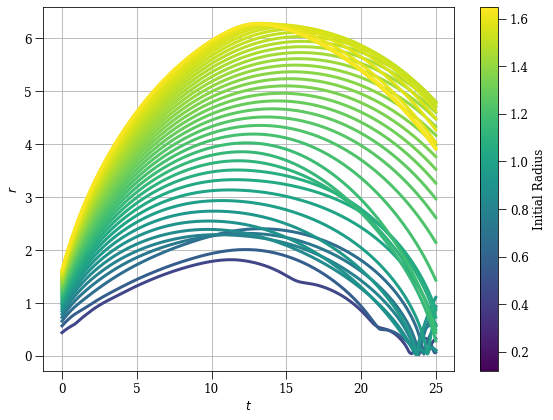

In [18]:
cmap = plt.cm.viridis
file = '/home/jsipple/10-23-9.h5'
file_path = file
try:
    # Load the simulation data
    params, results = load_simulation_data(file_path)
    tophat_radius = 1
    m_pert = 4/3 * np.pi * tophat_radius**3 * 1e-3 * rho_H
    H = 2/3
    G = 1
    N = params['N']

    # Extract initial radii
    initial_radii = results['r'][0, :]  # First time step for all shells
    r_min, r_max = initial_radii.min(), initial_radii.max()

    # Define normalization based on initial radii
    norm = plt.Normalize(r_min, r_max)

    # Plot all shells with color based on initial radii
    plt.figure(figsize=(8, 6))
    for idx in range(0, N, 25):
        if idx == 0:
            continue
        t, r = results['t'], results['r'][:, idx]
        r_initial = initial_radii[idx]
        plt.plot(t, r, color=cmap(norm(r_initial)), alpha=1)

    # Create ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Initial Radius')
    #cbar.set_ticks([1, 1.2, 1.4, 1.6, 1.8, 2])

    # Handle legend to avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(), loc='best')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r$')
    #plt.yscale('log')
    #plt.ylim(0, 10)
    plt.tight_layout()
    plt.savefig('thesis/fdm_traj.pdf')


except Exception as e:
    print(f"Error processing {file_path}: {e}")

In [6]:
pwd

'/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/notebooks'

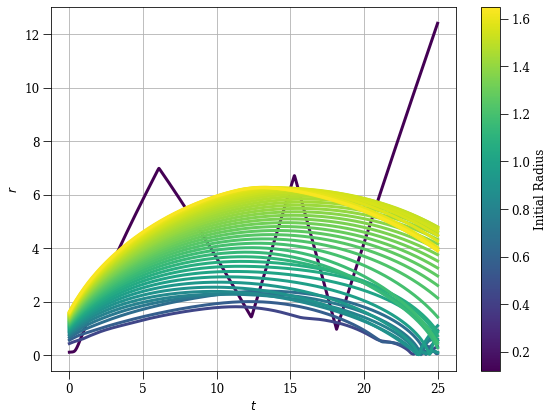

In [17]:
cmap = plt.cm.viridis
file = '10-23-9.h5'
file_path = file
try:
    # Load the simulation data
    params, results = load_simulation_data(file_path)
    tophat_radius = 1
    m_pert = 4/3 * np.pi * tophat_radius**3 * 1e-3 * rho_H
    H = 2/3
    G = 1
    N = params['N']

    # Extract initial radii
    initial_radii = results['r'][0, :]  # First time step for all shells
    r_min, r_max = initial_radii.min(), initial_radii.max()

    # Define normalization based on initial radii
    norm = plt.Normalize(r_min, r_max)

    # Plot all shells with color based on initial radii
    plt.figure(figsize=(8, 6))
    for idx in range(0, N, 25):
        t, r = results['t'], results['r'][:, idx]
        r_initial = initial_radii[idx]
        plt.plot(t, r, color=cmap(norm(r_initial)), alpha=1)

    # Create ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Initial Radius')
    #cbar.set_ticks([1, 1.2, 1.4, 1.6, 1.8, 2])

    # Handle legend to avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(), loc='best')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r$')
    #plt.yscale('log')
    #plt.ylim(0, 10)
    plt.tight_layout()
    plt.savefig('thesis/fdm_traj.pdf')


except Exception as e:
    print(f"Error processing {file_path}: {e}")

In [10]:
def rho_soliton(r_s, r):
    num = 1.95e7 * r_s**(-4)
    denom = (1 + 9.06e-2 * (r/r_s)**2)**8
    return num / denom

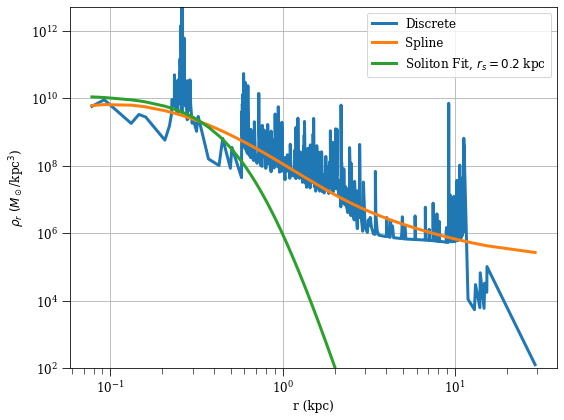

In [45]:
plt.figure(figsize=(8, 6))
params, results = load_simulation_data('10-23-9.h5')
rvals = results['r'][-1,:]
menc = results['m_enc'][-1,:]
rho_r = results['rho_r'][-1,:]
sorted_indices = np.argsort(rvals)
rvals = rvals[sorted_indices]
menc = menc[sorted_indices]
rho_r = rho_r[sorted_indices]
loglog_menc_spline = UnivariateSpline(np.log(rvals), np.log(menc), k=5, s=None)
b0 = loglog_menc_spline(np.log(rvals))
b1 = loglog_menc_spline.derivative(1)(np.log(rvals))
y = b0 - 3*np.log(rvals) - np.log(4*np.pi) + np.log(b1)

plt.plot(rvals*2.35, rho_r / (2.35**3) * 1e10, label=r'Discrete')
plt.plot(rvals*2.35, np.exp(y) / (2.35**3) * 1e10, label='Spline')
#plt.axhline(y=rho_r[0]/ (2.35**3) * 1e10/2, color='black', linestyle='--', label=r'$\rho(0)/2$')
plt.plot(rvals*2.35, rho_soliton(r_s=0.2, r=rvals*2.35), label=r'Soliton Fit, $r_s=0.2$ kpc')
#plt.plot(rvals*2.35, rho_soliton(r_s=1, r=rvals*2.35), label=r'Soliton Fit, $r_s=1$ kpc')
plt.ylim(1e2, None)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'r (kpc)')
plt.ylabel(r'$\rho_r$ $(M_\odot$/kpc$^3$)')
plt.legend()
plt.tight_layout()
plt.savefig('thesis/fdm_density2.pdf')

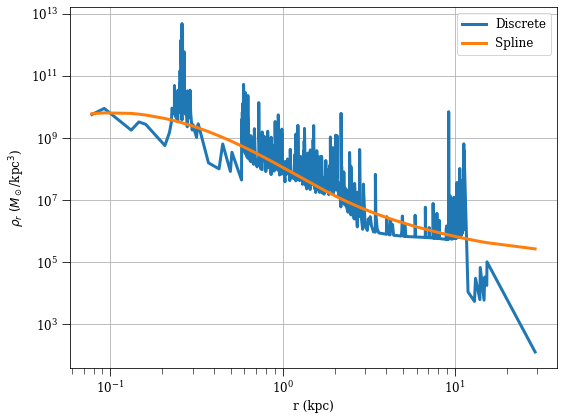

In [21]:
plt.figure(figsize=(8, 6))
params, results = load_simulation_data('10-23-9.h5')
rvals = results['r'][-1,:]
menc = results['m_enc'][-1,:]
rho_r = results['rho_r'][-1,:]
sorted_indices = np.argsort(rvals)
rvals = rvals[sorted_indices]
menc = menc[sorted_indices]
rho_r = rho_r[sorted_indices]
loglog_menc_spline = UnivariateSpline(np.log(rvals), np.log(menc), k=5, s=None)
b0 = loglog_menc_spline(np.log(rvals))
b1 = loglog_menc_spline.derivative(1)(np.log(rvals))
y = b0 - 3*np.log(rvals) - np.log(4*np.pi) + np.log(b1)

plt.plot(rvals*2.35, rho_r / (2.35**3) * 1e10, label=r'Discrete')
plt.plot(rvals*2.35, np.exp(y) / (2.35**3) * 1e10, label='Spline')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'r (kpc)')
plt.ylabel(r'$\rho_r$ $(M_\odot$/kpc$^3$)')
plt.legend()
plt.tight_layout()
plt.savefig('thesis/fdm_density.pdf')

In [15]:
cmap = plt.cm.viridis
file = 'thesis/power_law2.h5'
params, results = load_simulation_data(file)
v0 = results['v'][0,:]
r0 = results['r'][0,:]
print(r0, v0)

[0.0018588  0.00742364 0.01653517 ... 0.79973092 0.79986548 0.8       ] [-16.63593149  -2.07958001  -0.61605568 ...   0.53128962   0.5313798
   0.53146995]


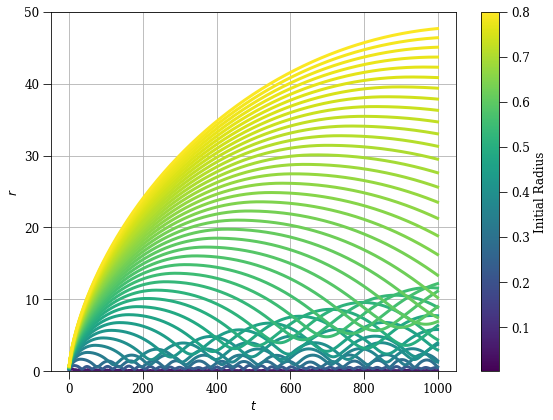

In [50]:
cmap = plt.cm.viridis
file = 'thesis/power_law2.h5'
file_path = file
try:
    # Load the simulation data
    params, results = load_simulation_data(file_path)
    tophat_radius = 1
    m_pert = 4/3 * np.pi * tophat_radius**3 * 1e-3 * rho_H
    H = 2/3
    G = 1
    N = params['N']

    # Extract initial radii
    initial_radii = results['r'][0, :]  # First time step for all shells
    r_min, r_max = initial_radii.min(), initial_radii.max()

    # Define normalization based on initial radii
    norm = plt.Normalize(r_min, r_max)

    # Plot all shells with color based on initial radii
    plt.figure(figsize=(8, 6))
    for idx in range(5, N, 50):
        t, r = results['t'], results['r'][:, idx]
        r_initial = initial_radii[idx]
        plt.plot(t, r, color=cmap(norm(r_initial)), alpha=1)

    # Create ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Initial Radius')
    #cbar.set_ticks([1, 1.2, 1.4, 1.6, 1.8, 2])

    # Handle legend to avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(), loc='best')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r$')
    plt.ylim(0, 50)
    plt.tight_layout()
    plt.savefig('thesis/profile_traj.pdf')


except Exception as e:
    print(f"Error processing {file_path}: {e}")

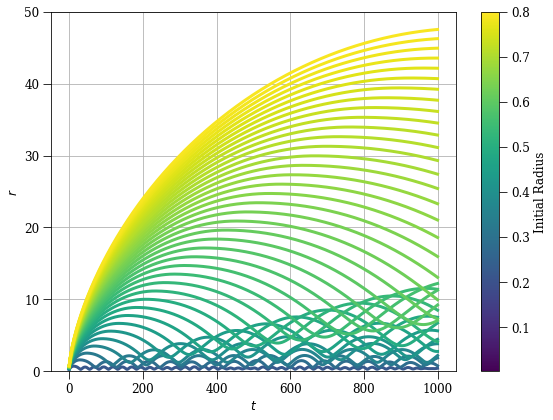

In [6]:
cmap = plt.cm.viridis
file = 'thesis/power_law2.h5'
file_path = file
try:
    # Load the simulation data
    params, results = load_simulation_data(file_path)
    tophat_radius = 1
    m_pert = 4/3 * np.pi * tophat_radius**3 * 1e-3 * rho_H
    H = 2/3
    G = 1
    N = params['N']

    # Extract initial radii
    initial_radii = results['r'][0, :]  # First time step for all shells
    r_min, r_max = initial_radii.min(), initial_radii.max()

    # Define normalization based on initial radii
    norm = plt.Normalize(r_min, r_max)

    # Plot all shells with color based on initial radii
    plt.figure(figsize=(8, 6))
    count = 0
    for idx in range(0, N, 50):
        if count == 0:
            count += 1
            continue
        count += 1
        t, r = results['t'], results['r'][:, idx]
        r_initial = initial_radii[idx]
        plt.plot(t, r, color=cmap(norm(r_initial)), alpha=1)

    # Create ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Initial Radius')
    #cbar.set_ticks([1, 1.2, 1.4, 1.6, 1.8, 2])

    # Handle legend to avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(), loc='best')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r$')
    plt.ylim(0, 50)
    plt.tight_layout()
    plt.savefig('thesis/profile_traj.pdf')


except Exception as e:
    print(f"Error processing {file_path}: {e}")

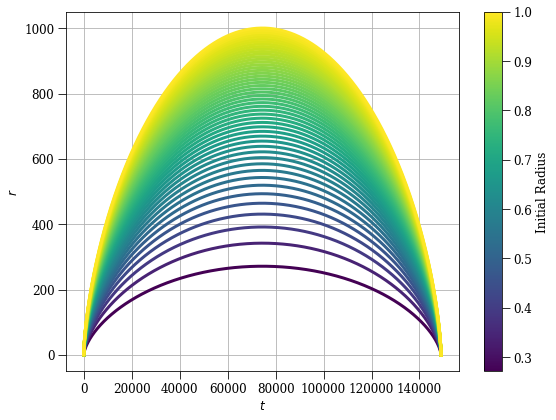

In [24]:
cmap = plt.cm.viridis
file = 'thesis/tophat.h5'
file_path = file
try:
    # Load the simulation data
    params, results = load_simulation_data(file_path)
    tophat_radius = 1
    m_pert = 4/3 * np.pi * tophat_radius**3 * 1e-3 * rho_H
    H = 2/3
    G = 1
    N = params['N']

    # Extract initial radii
    initial_radii = results['r'][0, :]  # First time step for all shells
    r_min, r_max = initial_radii.min(), initial_radii.max()

    # Define normalization based on initial radii
    norm = plt.Normalize(r_min, r_max)

    # Plot all shells with color based on initial radii
    plt.figure(figsize=(8, 6))
    for idx in range(0, N):
        t, r = results['t'], results['r'][:, idx]
        r_initial = initial_radii[idx]
        plt.plot(t, r, color=cmap(norm(r_initial)), alpha=1)

    # Create ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Initial Radius')
    #cbar.set_ticks([1, 1.2, 1.4, 1.6, 1.8, 2])

    # Handle legend to avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(), loc='best')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r$')
    #plt.ylim(0, 50)
    plt.tight_layout()
    plt.savefig('thesis/tophat_traj.pdf')


except Exception as e:
    print(f"Error processing {file_path}: {e}")

(11230,) (50,)


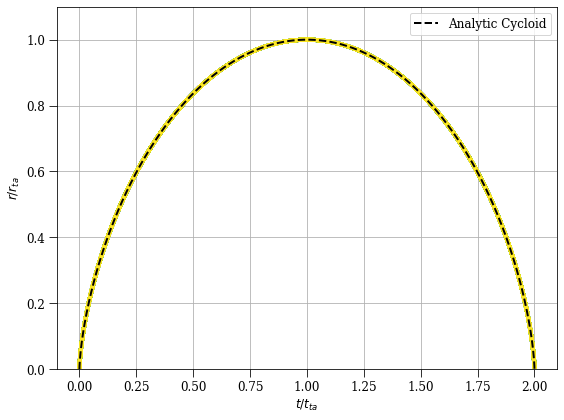

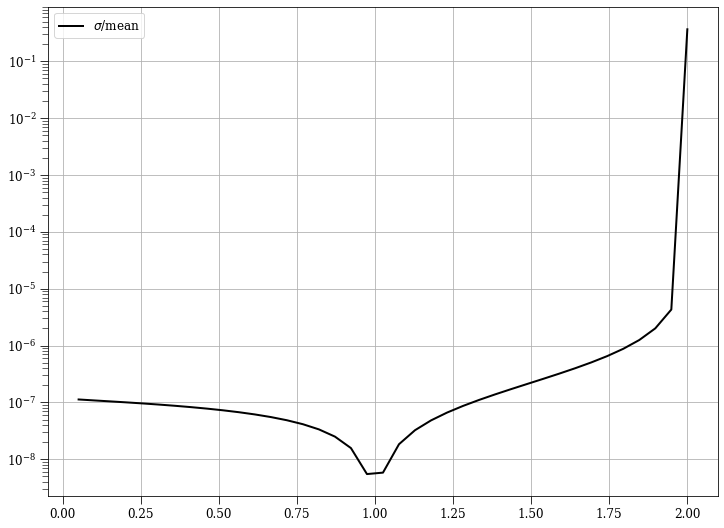

In [38]:
params, results = load_simulation_data('thesis/tophat.h5')
plot_results(results=results, params=params, sc=None, fn='thesis/tophat_selfsim.pdf');

### Power law large-ish angular momentum

In [34]:
r_max = 1
j_coef = 7e-1
N = 2_000
t_max = 1_000
safety_factor = 1e-3
save_dt = 1
delta = 1e-4
irs = 'equal_mass'
ivs = 'peculiar'
density_strategy = 'background_plus_power_law'
accel_strategy, ang_mom_strategy = 'grant_gmr_j_at_r_ta_soft', 'gmr' #'fdm4', 'const' 
energy_strategy = 'kin_grav_rot_absorbed'
softlen = 0
hbar2_over_m2 = 0
problematic_shell_strategy = 'nothing'
#tophat_radius = 1
point_mass = 0

tss = 'dyn_vel_acc'
mes = 'inclusive'
save_strategy = 'default'
r_min = 0
gamma = -2.5
thickness_coef = 0

config = make_config(N=N, r_min=r_min, r_max=r_max, t_max=t_max, j_coef=j_coef, save_dt=save_dt, density_strategy=density_strategy, safety_factor=safety_factor, stepper_strategy='leapfrog_hut',  timescale_strategy=tss, H=H0, initial_radius_strategy=irs, gamma=gamma, initial_v_strategy=ivs, accel_strategy=accel_strategy, ang_mom_strategy=ang_mom_strategy, save_filename=f'thesis/power_law3.h5', r_small=1, softlen=softlen, problematic_shell_strategy=problematic_shell_strategy, thickness_coef=thickness_coef, m_enc_strategy=mes, save_strategy=save_strategy, hbar2_over_m2=hbar2_over_m2, energy_strategy=energy_strategy, r_min_strategy='nothing', delta=delta)
sc, results, plotter = run_sc(config, profile=False, plot=False);

{'G': 1,
 'H': 0.6666666666666666,
 'N': 2000,
 'accel_strategy': 'grant_gmr_j_at_r_ta_soft',
 'ang_mom_strategy': 'gmr',
 'delta': 0.0001,
 'density_strategy': 'background_plus_power_law',
 'deque_size': 0,
 'drhodr_strategy': 'finite_diff',
 'dt': 1e-05,
 'dt_min': 0,
 'energy_strategy': 'kin_grav_rot_absorbed',
 'gamma': -2.5,
 'hbar2_over_m2': 0,
 'initial_mass_strategy': 'integrated_mass',
 'initial_radius_strategy': 'equal_mass',
 'initial_v_strategy': 'peculiar',
 'j_coef': 0.7,
 'm_enc_strategy': 'inclusive',
 'm_pert': 1,
 'next_save_time': 0,
 'num_crossing': 0,
 'point_mass': 0,
 'point_mass_strategy': 'rmin_rho_r',
 'polytropic_coef': 0,
 'polytropic_index': -1,
 'pressure_strategy': 'zero',
 'problematic_shell_strategy': 'nothing',
 'r0_min': 0.0005,
 'r_max': 1,
 'r_min': 0,
 'r_min_strategy': 'nothing',
 'r_small': 1,
 'r_ta_strategy': 'r_ta_cycloid',
 'relaxation_time': 0,
 'rho_bar': 0.05305164769729845,
 'safety_factor': 0.001,
 'save_dt': 1,
 'save_filename': 'thesis

2025-11-21 04:33:19,568 - collapse - INFO - Simulation setup complete


2025-11-21 04:36:49,200 - DEBUG - Saved dataset t with shape (1001,)
2025-11-21 04:36:49,201 - DEBUG - Saved dataset dt with shape (1001,)
2025-11-21 04:36:49,221 - DEBUG - Saved dataset r with shape (1001, 2000)
2025-11-21 04:36:49,237 - DEBUG - Saved dataset v with shape (1001, 2000)
2025-11-21 04:36:49,253 - DEBUG - Saved dataset a with shape (1001, 2000)
2025-11-21 04:36:49,269 - DEBUG - Saved dataset m_enc with shape (1001, 2000)
2025-11-21 04:36:49,285 - DEBUG - Saved dataset rho_r with shape (1001, 2000)
2025-11-21 04:36:49,286 - WARNING - Skipping pressure because all values are None
2025-11-21 04:36:49,287 - WARNING - Skipping dpressure_drho because all values are None
2025-11-21 04:36:49,287 - WARNING - Skipping rho_prime because all values are None
2025-11-21 04:36:49,304 - DEBUG - Saved dataset e_tot with shape (1001, 2000)
2025-11-21 04:36:49,319 - DEBUG - Saved dataset e_g with shape (1001, 2000)
2025-11-21 04:36:49,334 - DEBUG - Saved dataset e_k with shape (1001, 2000)


2025-11-21 04:36:49,381 - DEBUG - Saved dataset m with shape (1001, 2000)
2025-11-21 04:36:49,383 - DEBUG - Saved dataset deque with shape (1001, 0)
2025-11-21 04:36:49,384 - DEBUG - Saved dataset t_true with shape (1001,)
2025-11-21 04:36:50,296 - INFO - Saved simulation data and parameters to thesis/power_law3.h5


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: divide by zero encountered in true_divide


(1001,) (2000,)


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zer

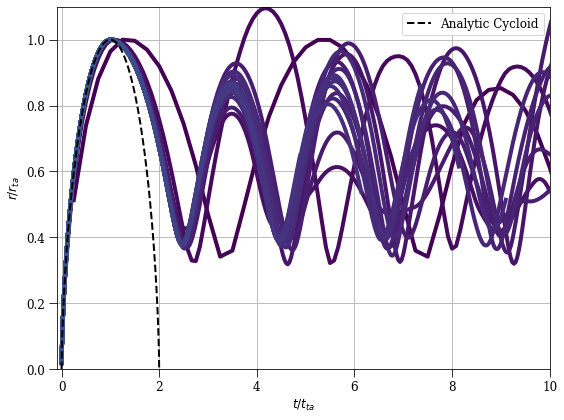

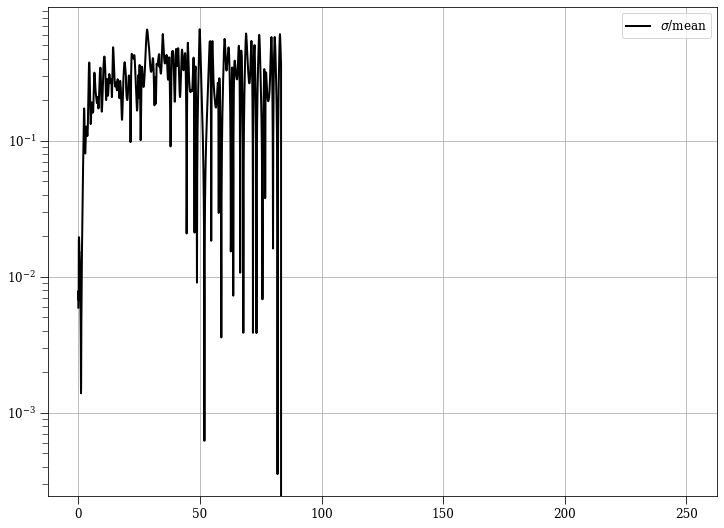

In [40]:

plot_results(results=results, params=None, sc=sc, fn=None, nta=10);

In [33]:
results['v'][0,0]

0.03939236688164279

{'G': 1,
 'H': 0.6666666666666666,
 'N': 2000,
 'accel_strategy': 'grant_gmr_j_at_r_ta_soft',
 'ang_mom_strategy': 'gmr',
 'delta': 0.001,
 'density_strategy': 'background_plus_power_law',
 'deque_size': 0,
 'drhodr_strategy': 'finite_diff',
 'dt': 1e-05,
 'dt_min': 0,
 'energy_strategy': 'kin_grav_rot_absorbed',
 'gamma': -2.5,
 'hbar2_over_m2': 0,
 'initial_mass_strategy': 'integrated_mass',
 'initial_radius_strategy': 'equal_mass',
 'initial_v_strategy': 'peculiar',
 'j_coef': 0.7,
 'm_enc_strategy': 'inclusive',
 'm_pert': 1,
 'next_save_time': 0,
 'num_crossing': 0,
 'point_mass': 0,
 'point_mass_strategy': 'rmin_rho_r',
 'polytropic_coef': 0,
 'polytropic_index': -1,
 'pressure_strategy': 'zero',
 'problematic_shell_strategy': 'nothing',
 'r0_min': 0.0004,
 'r_max': 0.8,
 'r_min': 0,
 'r_min_strategy': 'nothing',
 'r_small': 1,
 'r_ta_strategy': 'r_ta_cycloid',
 'relaxation_time': 0,
 'rho_bar': 0.05305164769729845,
 'safety_factor': 0.0001,
 'save_dt': 1,
 'save_filename': 'thes

2025-11-19 05:38:25,257 - collapse - INFO - Simulation setup complete


2025-11-19 08:23:14,553 - DEBUG - Saved dataset t with shape (1001,)
2025-11-19 08:23:14,555 - DEBUG - Saved dataset dt with shape (1001,)
2025-11-19 08:23:14,584 - DEBUG - Saved dataset r with shape (1001, 2000)
2025-11-19 08:23:14,607 - DEBUG - Saved dataset v with shape (1001, 2000)
2025-11-19 08:23:14,627 - DEBUG - Saved dataset a with shape (1001, 2000)
2025-11-19 08:23:14,646 - DEBUG - Saved dataset m_enc with shape (1001, 2000)
2025-11-19 08:23:14,663 - DEBUG - Saved dataset rho_r with shape (1001, 2000)
2025-11-19 08:23:14,664 - WARNING - Skipping pressure because all values are None
2025-11-19 08:23:14,665 - WARNING - Skipping dpressure_drho because all values are None
2025-11-19 08:23:14,665 - WARNING - Skipping rho_prime because all values are None


2025-11-19 08:23:14,684 - DEBUG - Saved dataset e_tot with shape (1001, 2000)
2025-11-19 08:23:14,702 - DEBUG - Saved dataset e_g with shape (1001, 2000)
2025-11-19 08:23:14,719 - DEBUG - Saved dataset e_k with shape (1001, 2000)
2025-11-19 08:23:14,736 - DEBUG - Saved dataset e_r with shape (1001, 2000)
2025-11-19 08:23:14,737 - WARNING - Skipping e_p because all values are None
2025-11-19 08:23:14,737 - WARNING - Skipping e_q because all values are None
2025-11-19 08:23:14,739 - DEBUG - Saved dataset t_dyn with shape (1001,)
2025-11-19 08:23:14,740 - DEBUG - Saved dataset t_vel with shape (1001,)
2025-11-19 08:23:14,741 - DEBUG - Saved dataset t_acc with shape (1001,)
2025-11-19 08:23:14,742 - WARNING - Skipping t_cross because all values are None
2025-11-19 08:23:14,742 - WARNING - Skipping t_crossa because all values are None
2025-11-19 08:23:14,743 - WARNING - Skipping t_cross2 because all values are None
2025-11-19 08:23:14,744 - WARNING - Skipping t_zero because all values are N

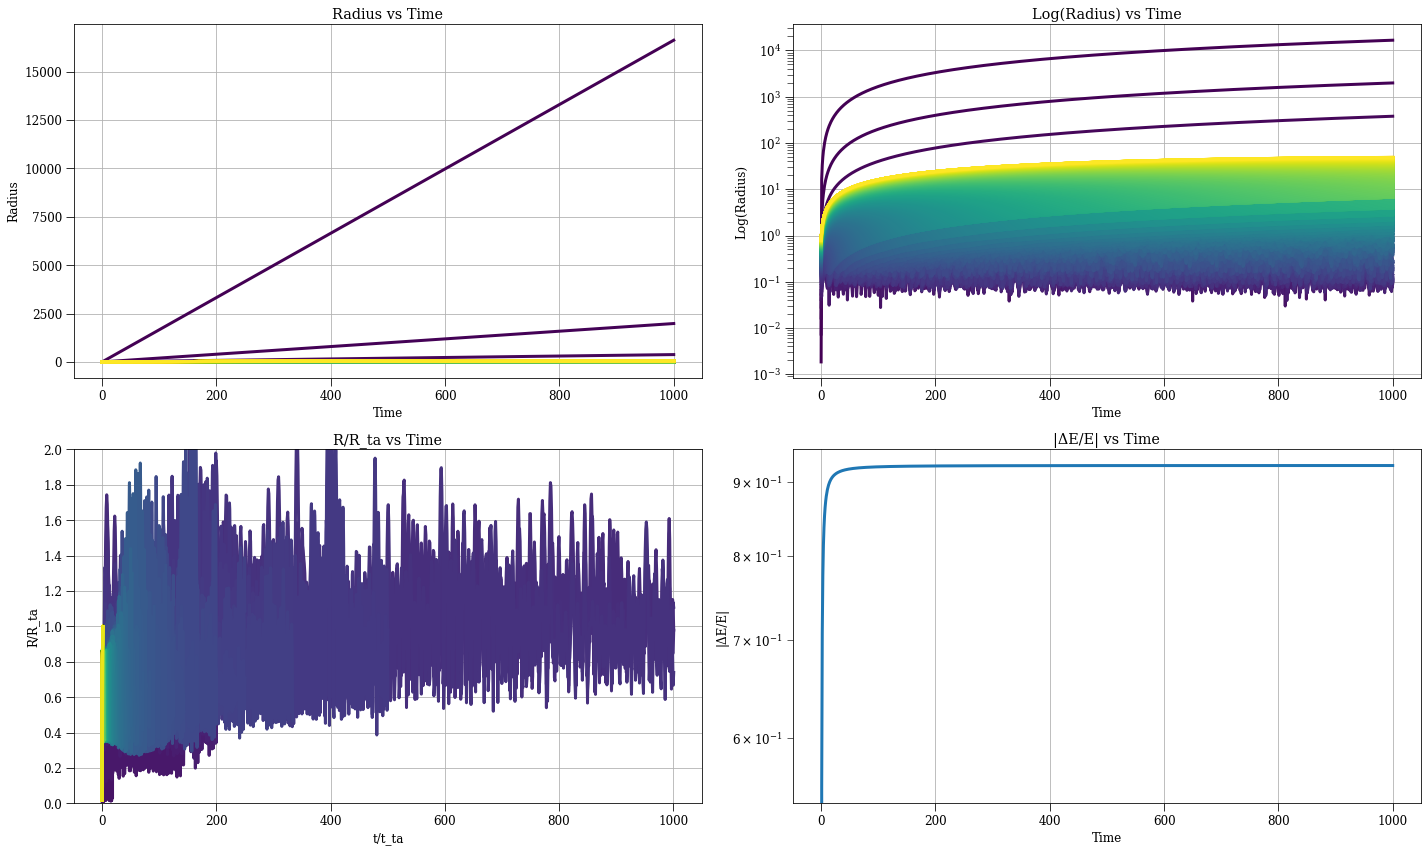

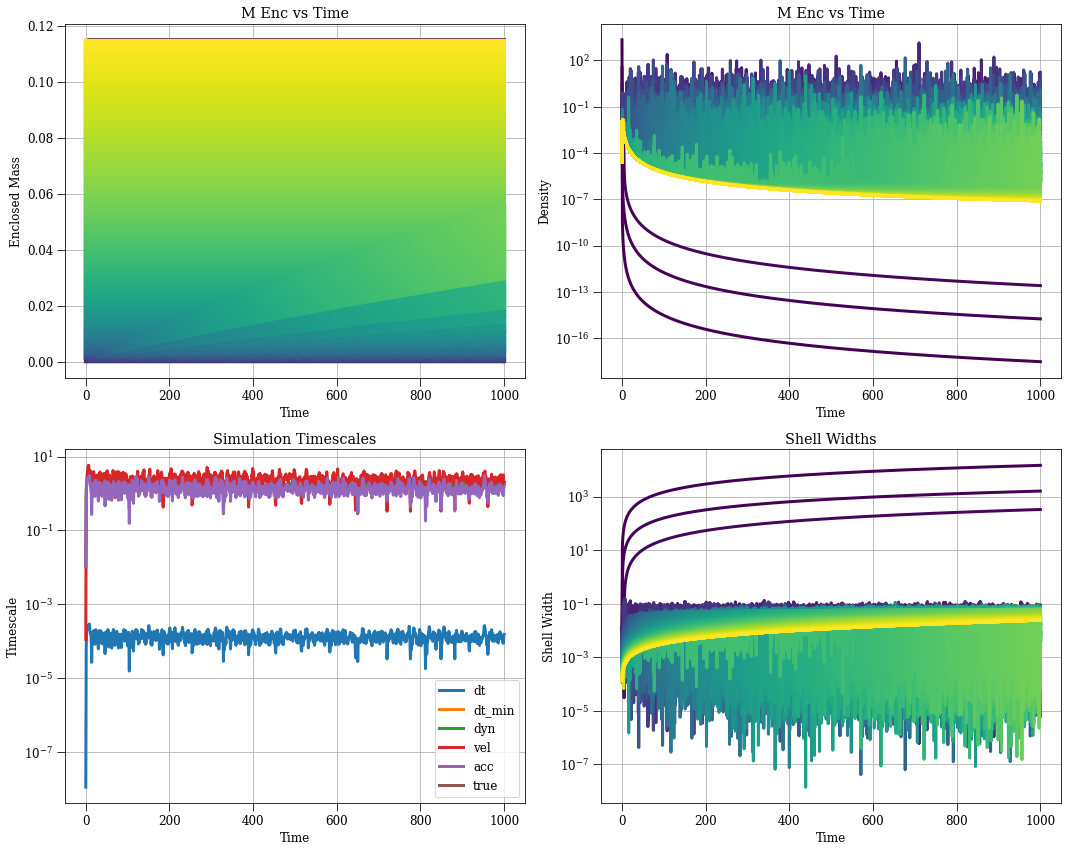

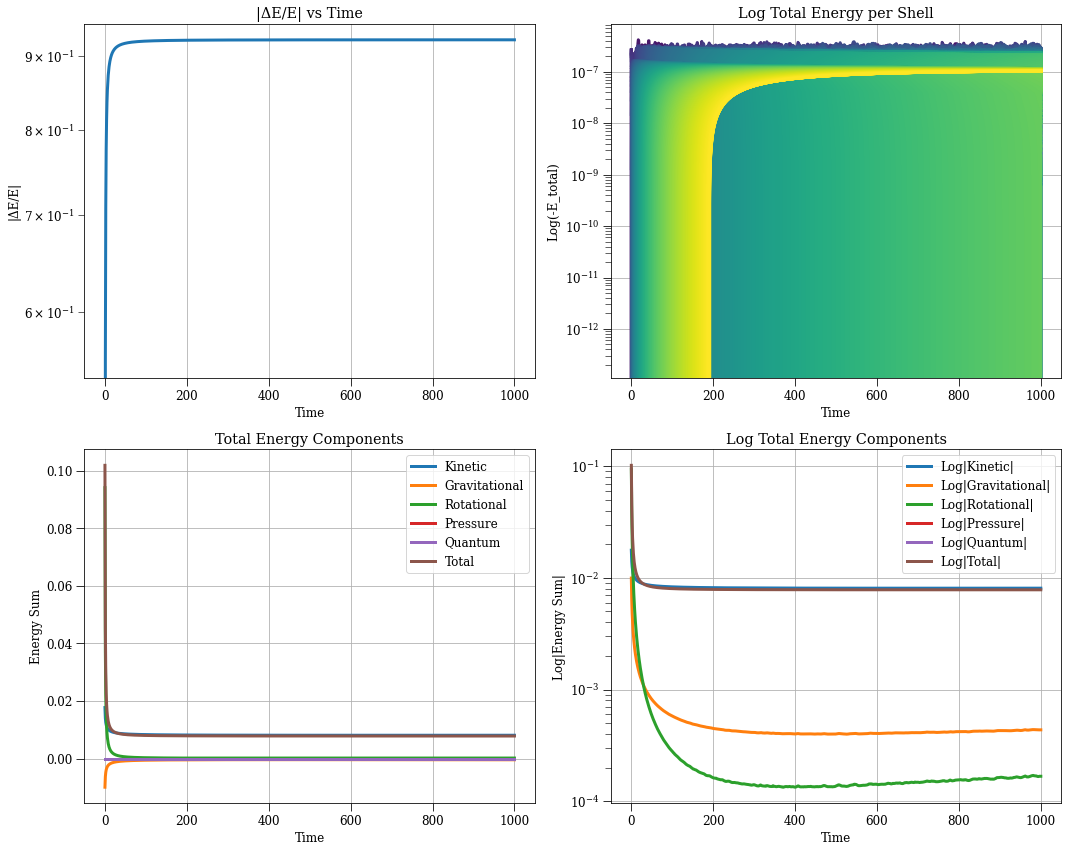

In [25]:
r_max = 0.8
j_coef = 7e-1
N = 2_000
t_max = 1_000
safety_factor = 1e-4
save_dt = 1
delta = 1e-3
irs = 'equal_mass'
ivs = 'peculiar'
density_strategy = 'background_plus_power_law'
accel_strategy, ang_mom_strategy = 'grant_gmr_j_at_r_ta_soft', 'gmr' #'fdm4', 'const' 
energy_strategy = 'kin_grav_rot_absorbed'
softlen = 0
hbar2_over_m2 = 0
problematic_shell_strategy = 'nothing'
#tophat_radius = 1
point_mass = 0

tss = 'dyn_vel_acc'
mes = 'inclusive'
save_strategy = 'default'
r_min = 0
gamma = -2.5
thickness_coef = 0

config = make_config(N=N, r_min=r_min, r_max=r_max, t_max=t_max, j_coef=j_coef, save_dt=save_dt, density_strategy=density_strategy, safety_factor=safety_factor, stepper_strategy='leapfrog_hut',  timescale_strategy=tss, H=H0, initial_radius_strategy=irs, gamma=gamma, initial_v_strategy=ivs, accel_strategy=accel_strategy, ang_mom_strategy=ang_mom_strategy, save_filename=f'thesis/power_law2.h5', r_small=1, softlen=softlen, problematic_shell_strategy=problematic_shell_strategy, thickness_coef=thickness_coef, m_enc_strategy=mes, save_strategy=save_strategy, hbar2_over_m2=hbar2_over_m2, energy_strategy=energy_strategy, r_min_strategy='nothing', delta=delta)
sc, results, plotter = run_sc(config, profile=False, plot=True);

/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: divide by zero encountered in true_divide


(1001,) (2000,)


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zer

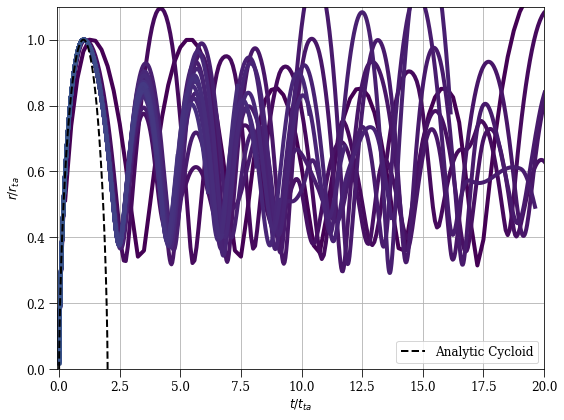

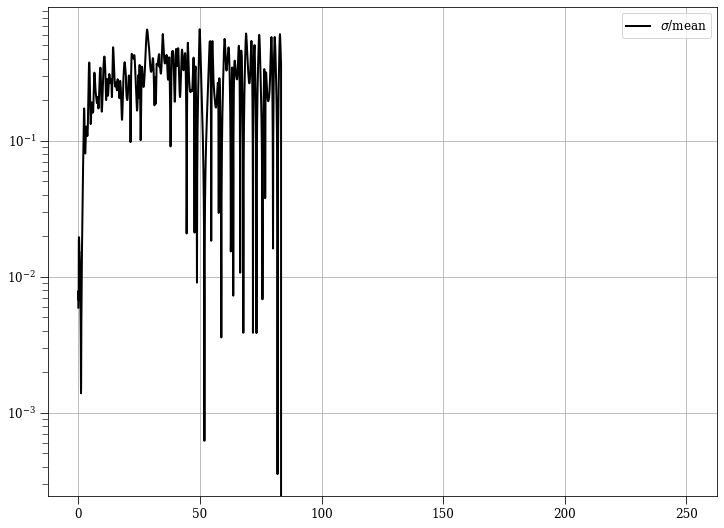

In [43]:
params, results = load_simulation_data('thesis/power_law3.h5')
plot_results(results=results, params=params, sc=None, nta=20, fn='thesis/profile_selfsim_traj.pdf');

(1001,) (2000,)


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: divide by zero encountered in true_divide
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: divide by zer

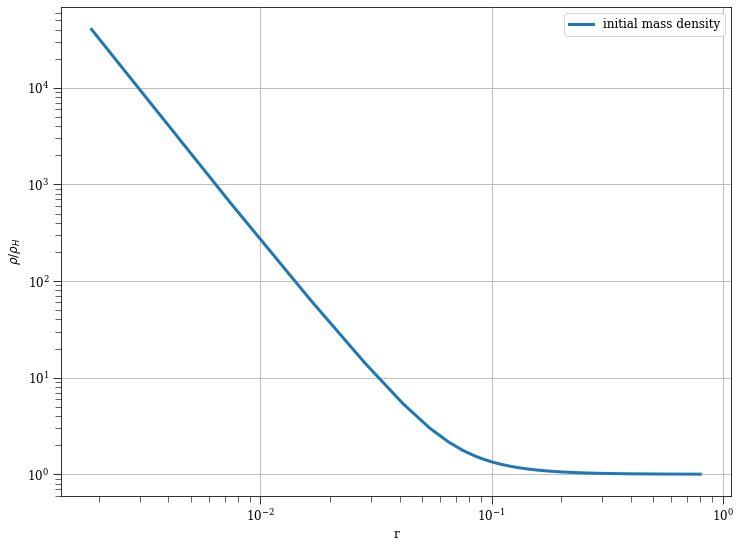

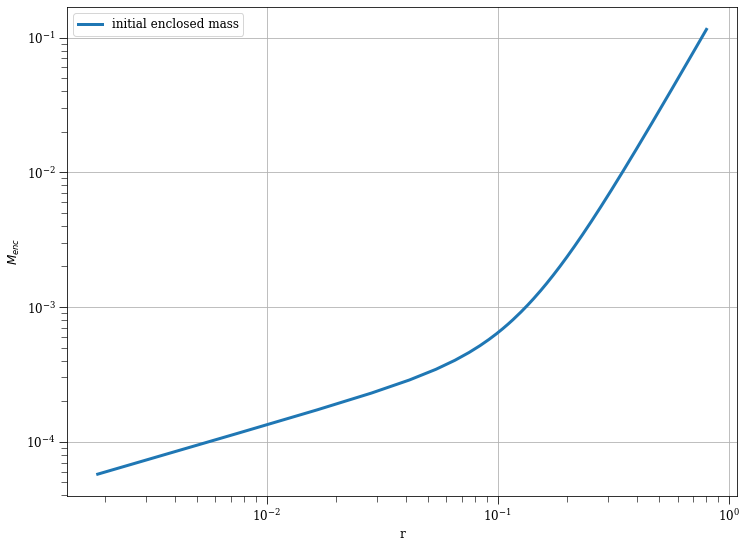

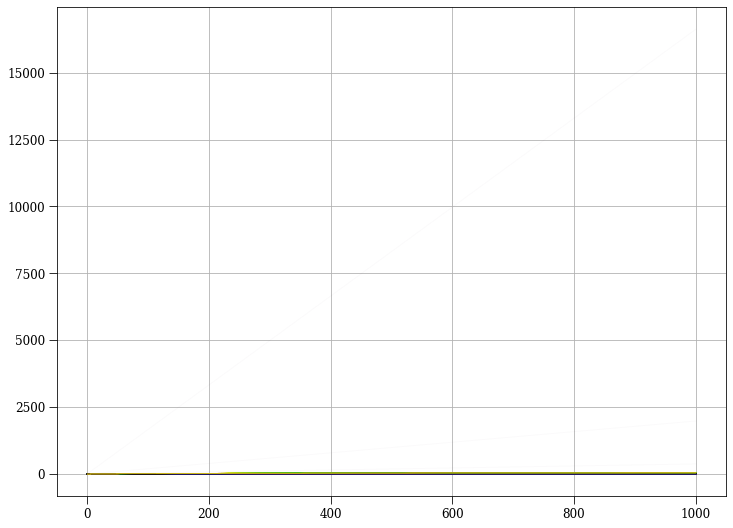

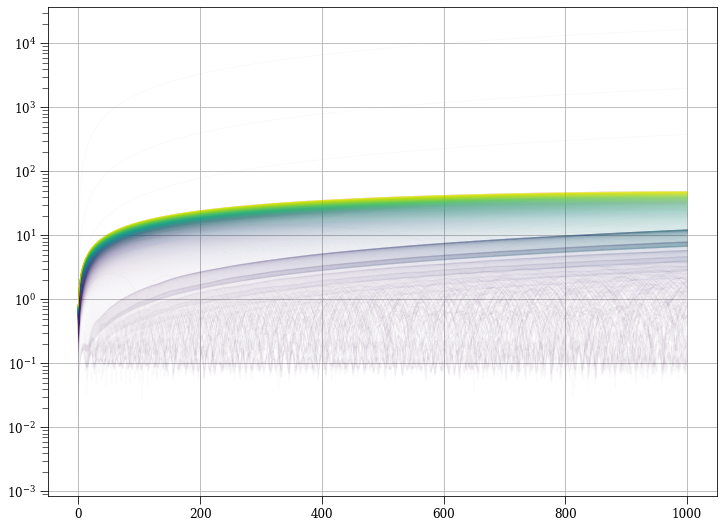

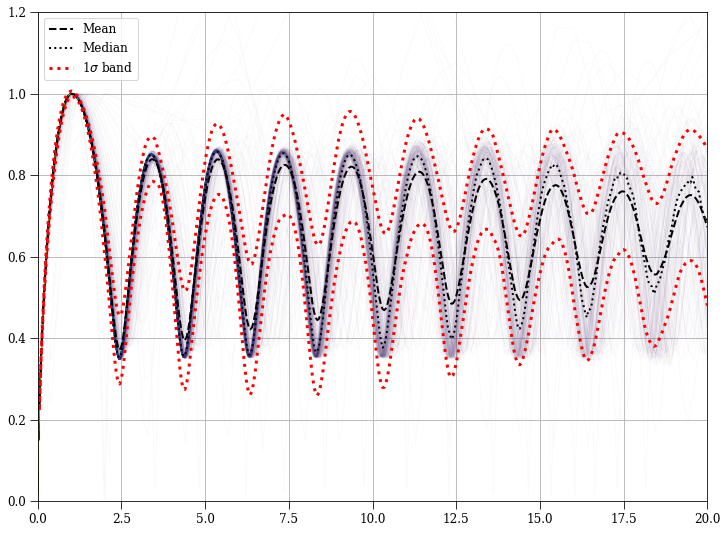

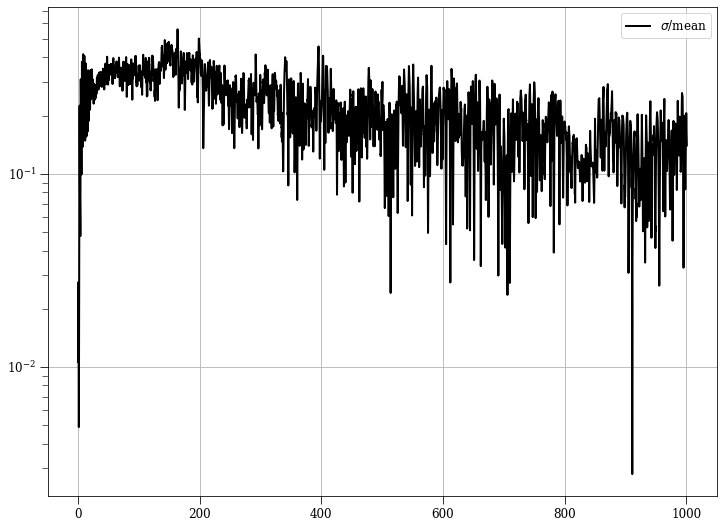

In [26]:
plot_results(results, sc, nta=20);

{'G': 1,
 'H': 0.6666666666666666,
 'N': 1000,
 'accel_strategy': 'grant_gmr_j_at_r_ta_soft',
 'ang_mom_strategy': 'gmr',
 'delta': 0.001,
 'density_strategy': 'background_plus_power_law',
 'deque_size': 0,
 'drhodr_strategy': 'finite_diff',
 'dt': 1e-05,
 'dt_min': 0,
 'energy_strategy': 'kin_grav_rot_absorbed',
 'gamma': -2.5,
 'hbar2_over_m2': 0,
 'initial_mass_strategy': 'integrated_mass',
 'initial_radius_strategy': 'equal_mass',
 'initial_v_strategy': 'peculiar',
 'j_coef': 0.9,
 'm_enc_strategy': 'inclusive',
 'm_pert': 1,
 'next_save_time': 0,
 'num_crossing': 0,
 'point_mass': 0,
 'point_mass_strategy': 'rmin_rho_r',
 'polytropic_coef': 0,
 'polytropic_index': -1,
 'pressure_strategy': 'zero',
 'problematic_shell_strategy': 'nothing',
 'r0_min': 0.001,
 'r_max': 1,
 'r_min': 0,
 'r_min_strategy': 'nothing',
 'r_small': 1,
 'r_ta_strategy': 'r_ta_cycloid',
 'relaxation_time': 0,
 'rho_bar': 0.05305164769729845,
 'safety_factor': 0.001,
 'save_dt': 1,
 'save_filename': 'thesis/p

2025-11-19 01:32:09,896 - collapse - INFO - Simulation setup complete


2025-11-19 02:39:13,491 - DEBUG - Saved dataset t with shape (6001,)
2025-11-19 02:39:13,493 - DEBUG - Saved dataset dt with shape (6001,)


2025-11-19 02:39:13,592 - DEBUG - Saved dataset r with shape (6001, 1000)
2025-11-19 02:39:13,677 - DEBUG - Saved dataset v with shape (6001, 1000)
2025-11-19 02:39:13,764 - DEBUG - Saved dataset a with shape (6001, 1000)
2025-11-19 02:39:13,856 - DEBUG - Saved dataset m_enc with shape (6001, 1000)
2025-11-19 02:39:13,942 - DEBUG - Saved dataset rho_r with shape (6001, 1000)
2025-11-19 02:39:13,943 - WARNING - Skipping pressure because all values are None
2025-11-19 02:39:13,944 - WARNING - Skipping dpressure_drho because all values are None
2025-11-19 02:39:13,945 - WARNING - Skipping rho_prime because all values are None
2025-11-19 02:39:14,037 - DEBUG - Saved dataset e_tot with shape (6001, 1000)
2025-11-19 02:39:14,121 - DEBUG - Saved dataset e_g with shape (6001, 1000)
2025-11-19 02:39:14,205 - DEBUG - Saved dataset e_k with shape (6001, 1000)
2025-11-19 02:39:14,291 - DEBUG - Saved dataset e_r with shape (6001, 1000)
2025-11-19 02:39:14,293 - WARNING - Skipping e_p because all va

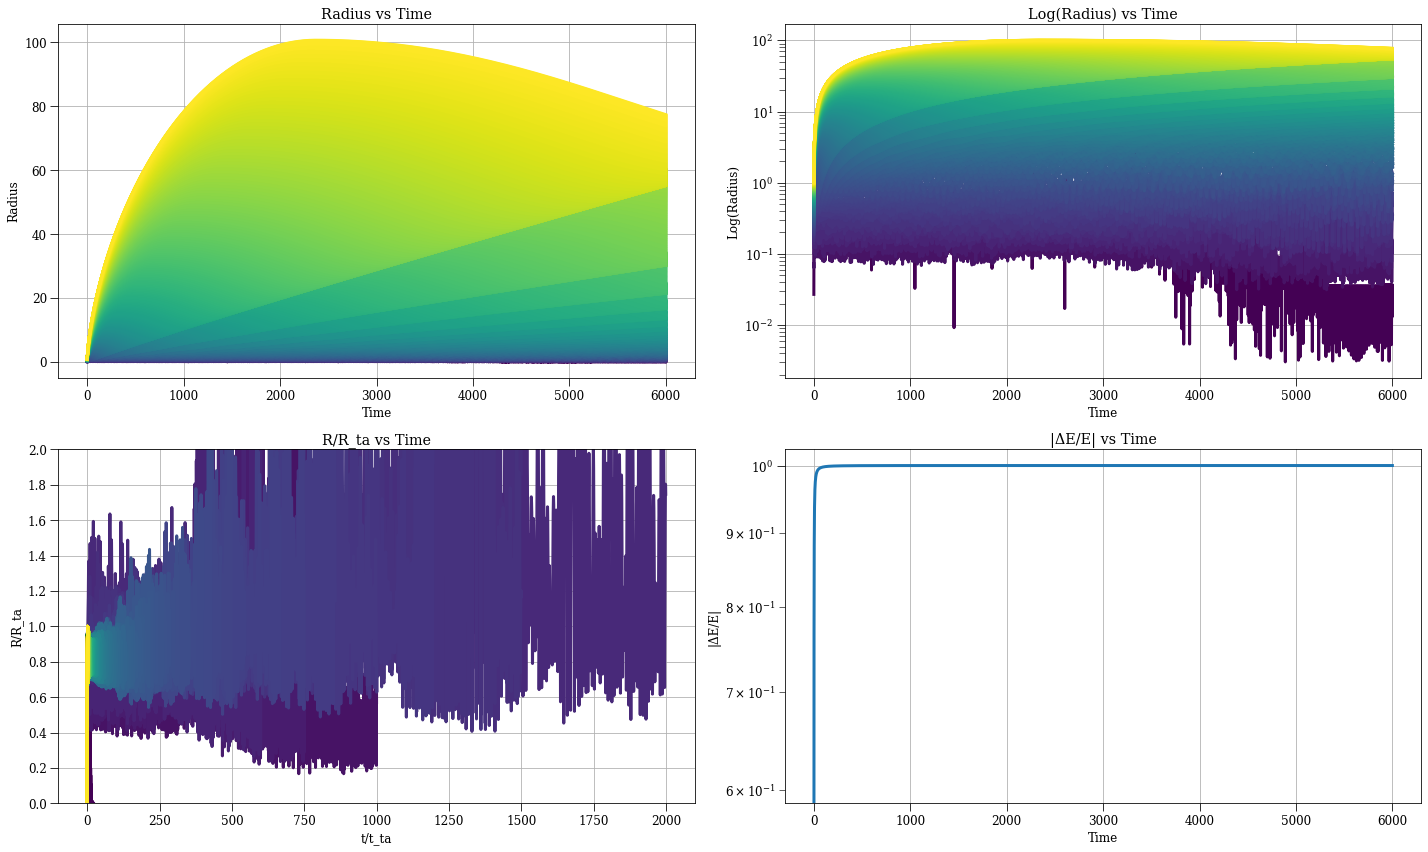

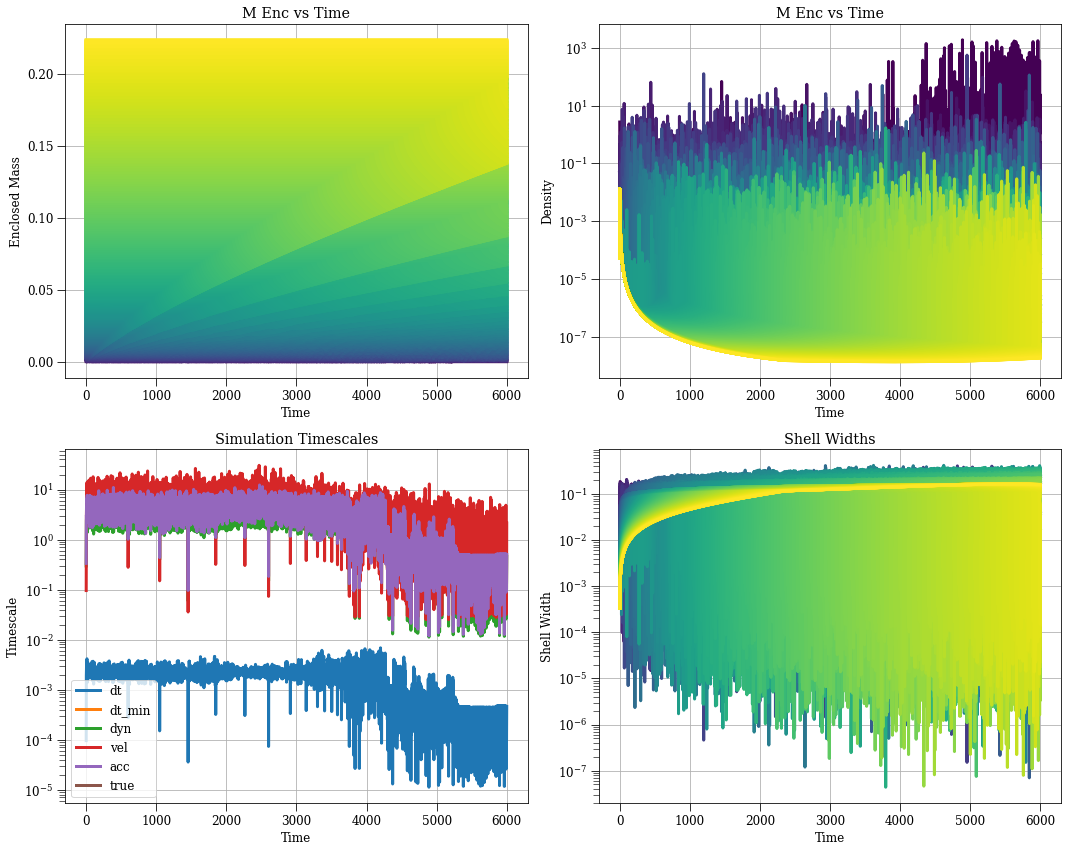

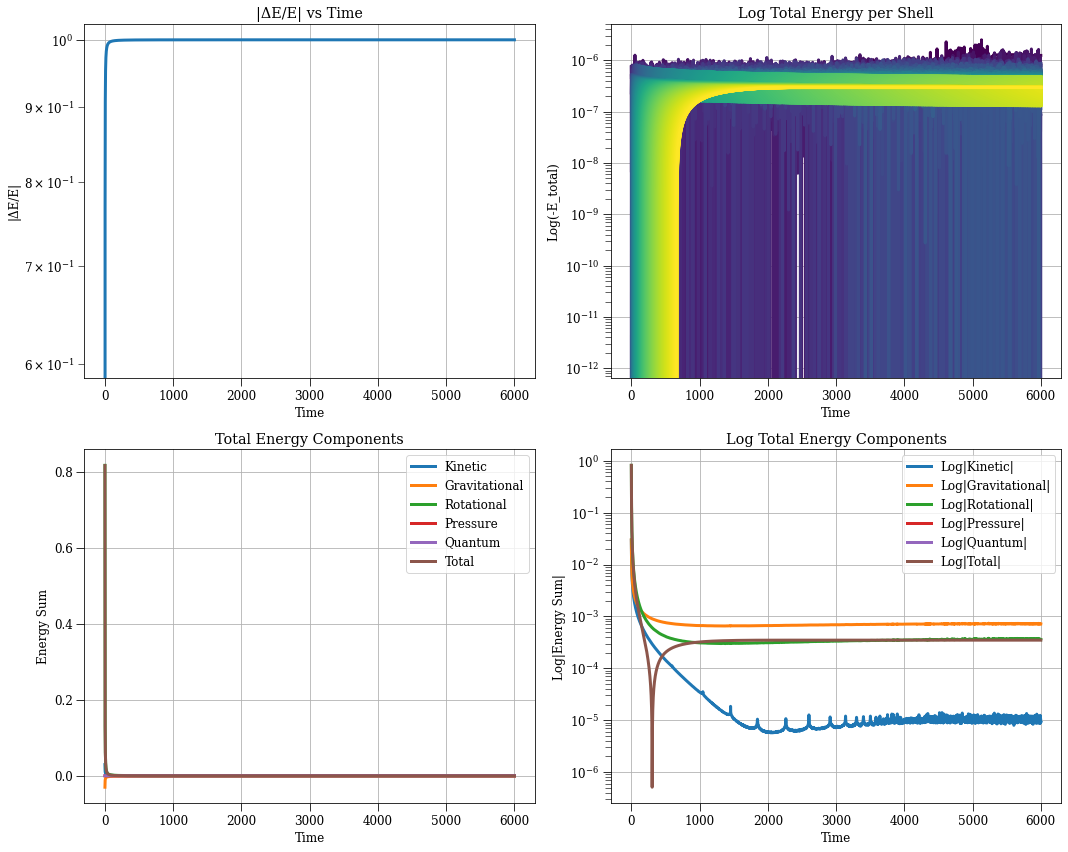

In [4]:
r_max = 1
j_coef = 9e-1
N = 1000
t_max = 6_000
safety_factor = 1e-3
save_dt = 1
delta = 1e-3
irs = 'equal_mass'
ivs = 'peculiar'
density_strategy = 'background_plus_power_law'
accel_strategy, ang_mom_strategy = 'grant_gmr_j_at_r_ta_soft', 'gmr' #'fdm4', 'const' 
energy_strategy = 'kin_grav_rot_absorbed'
softlen = 0
hbar2_over_m2 = 0
problematic_shell_strategy = 'nothing'
#tophat_radius = 1
point_mass = 0

tss = 'dyn_vel_acc'
mes = 'inclusive'
save_strategy = 'default'
r_min = 0
gamma = -2.5
thickness_coef = 0

config = make_config(N=N, r_min=r_min, r_max=r_max, t_max=t_max, j_coef=j_coef, save_dt=save_dt, density_strategy=density_strategy, safety_factor=safety_factor, stepper_strategy='leapfrog_hut',  timescale_strategy=tss, H=H0, initial_radius_strategy=irs, gamma=gamma, initial_v_strategy=ivs, accel_strategy=accel_strategy, ang_mom_strategy=ang_mom_strategy, save_filename=f'thesis/power_law.h5', r_small=1, softlen=softlen, problematic_shell_strategy=problematic_shell_strategy, thickness_coef=thickness_coef, m_enc_strategy=mes, save_strategy=save_strategy, hbar2_over_m2=hbar2_over_m2, energy_strategy=energy_strategy, r_min_strategy='nothing', delta=delta)
sc, results, plotter = run_sc(config, profile=False, plot=True);

(6001,) (1000,)


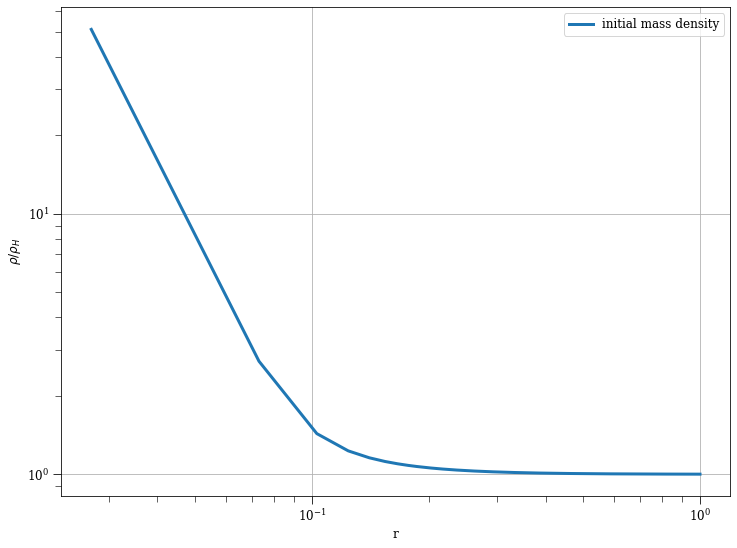

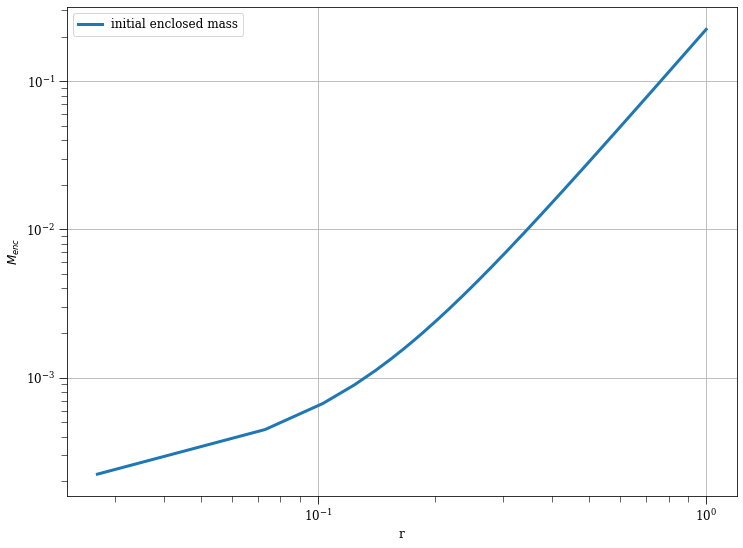

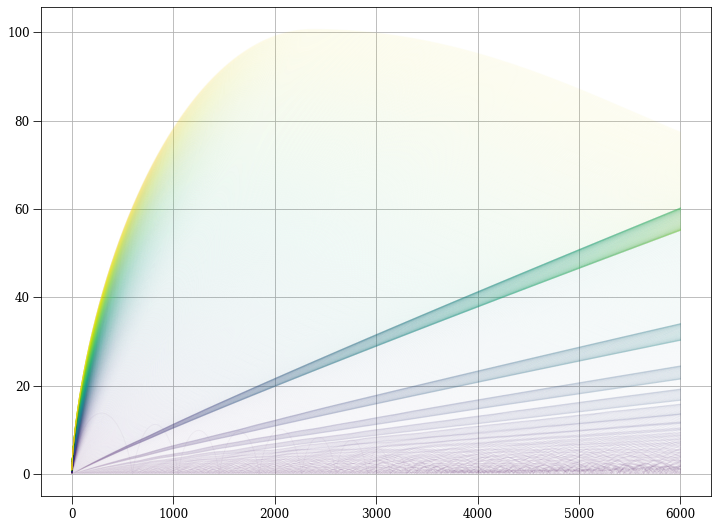

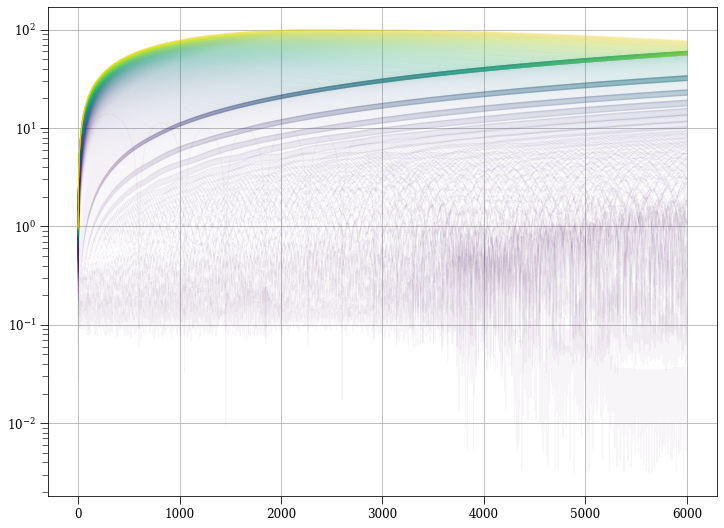

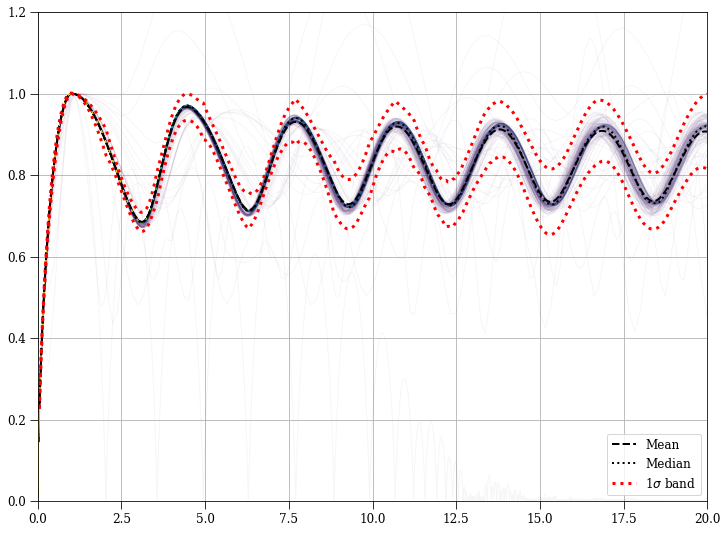

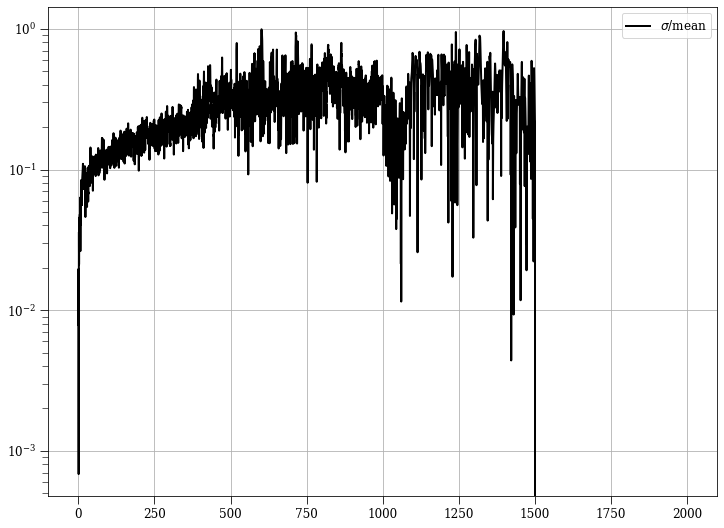

In [7]:
plot_results(results, sc, nta=20);

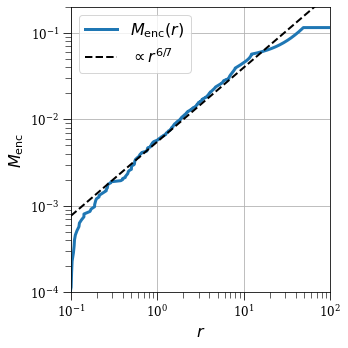

In [37]:
plt.figure(figsize=(5, 5))
params, snapshots = load_simulation_data(f'thesis/power_law2.h5')
idx = -1
rvals = snapshots['r'][idx,:]
sorted_indices = np.argsort(rvals)
rvals = rvals[sorted_indices]
mencvals = snapshots['m_enc'][idx,sorted_indices]
tval = snapshots['t'][idx]
plt.loglog(rvals, mencvals, color='C0', ls='-', label=r'$M_{\rm enc}(r)$')


rvals = np.logspace(-1, 2, 100)    
#plt.loglog(rvals, (rvals/1e2)**1.57, ls='--', color='black', label=r'$r^{1.57}$', lw=2, alpha=1)
rvals = np.logspace(-1,2, 100)    
#plt.loglog(rvals, 1e-2*(rvals/2e0)**1, ls=':', color='black', label=r'$r^{1}$', lw=2, alpha=1)
plt.loglog(rvals, 1e-2*(rvals/2e0)**(6/7), ls='--', color='black', label=r'$\propto r^{6/7}$', lw=2, alpha=1)
plt.xlim(1e-1, 1e2)
plt.ylim(1e-4, 2e-1)
plt.xlabel(r'$r$', fontsize=16)
plt.ylabel(r'$M_{\rm enc}$', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('thesis/profile_menc.pdf')